In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

In [3]:

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

In [4]:
# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

In [5]:
# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [8]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [9]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 4571

Testing
Number of Labels: 1311


In [10]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [12]:
model = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [14]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - accuracy: 0.4407 - loss: 1.1409 - val_accuracy: 0.6590 - val_loss: 0.8642 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.7746 - loss: 0.5992 - val_accuracy: 0.7613 - val_loss: 0.5743 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.8233 - loss: 0.4583 - val_accuracy: 0.8139 - val_loss: 0.4565 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.8670 - loss: 0.3456 - val_accuracy: 0.8436 - val_loss: 0.4149 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9061 - loss: 0.2581 - val_accuracy: 0.8917 - val_loss: 0.2892 - learning_rate: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.9262 - loss: 0.2101 - val_accuracy: 0.9016 - val_loss: 0.2403 - learning_rate: 0.0010
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - accuracy: 0.9

In [15]:
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9869 - loss: 0.0655
Test accuracy: 98.0931%


In [16]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       300
           1       0.96      0.97      0.97       306
           2       0.99      1.00      1.00       405
           3       0.97      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



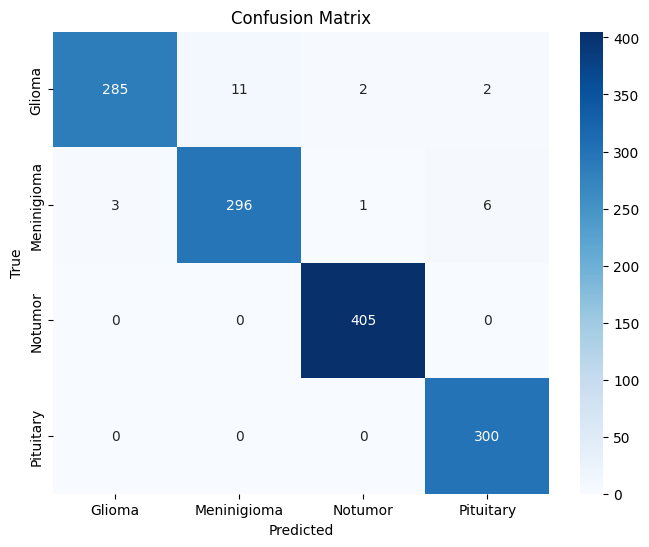

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
model.save('SSL_80-20.h5')

In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from datetime import datetime
import shutil

# Define paths
MODEL_PATH = "SSL_80-20.h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "BT100/unlabelled"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
LOW_CONF_FOLDER = "BT100/low_confidence"  # Folder for low-confidence images
CONFIDENCE_THRESHOLD = 0.98
IMG_SIZE = (168, 168)  # Use the same image size as during training

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)
os.makedirs(LOW_CONF_FOLDER, exist_ok=True)  # Ensure low-confidence folder exists

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')  # Load as grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Debugging print statements
    print(f"{img_file} -> Class: {CLASS_NAMES[class_id]}, Confidence: {confidence:.2f}")

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])

        # Ensure unique filenames to prevent overwriting
        unique_filename = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{img_file}"
        output_path = os.path.join(class_folder, unique_filename)

        print(f"Moving {img_file} to {output_path}")
        shutil.move(img_path, output_path)  # Move instead of copy
    else:
        low_conf_path = os.path.join(LOW_CONF_FOLDER, img_file)
        shutil.move(img_path, low_conf_path)
        print(f"Moved low-confidence image {img_file} to {LOW_CONF_FOLDER}")

print("✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.")


  0%|          | 0/1141 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 1/1141 [00:01<25:24,  1.34s/it]

Tr-gl_0780.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0780.jpg to BT100/Training/glioma/20250328_234023_Tr-gl_0780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  0%|          | 2/1141 [00:01<13:48,  1.37it/s]

Tr-no_0585.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0585.jpg to BT100/Training/notumor/20250328_234023_Tr-no_0585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  0%|          | 3/1141 [00:01<09:42,  1.95it/s]

Tr-gl_0648.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0648.jpg to BT100/Training/glioma/20250328_234023_Tr-gl_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 4/1141 [00:01<06:40,  2.84it/s]

Tr-gl_0325.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0325.jpg to BT100/Training/glioma/20250328_234023_Tr-gl_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 5/1141 [00:02<05:25,  3.50it/s]

Tr-me_0990.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0990.jpg to BT100/Training/meningioma/20250328_234024_Tr-me_0990.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0150.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0150.jpg to BT100/Training/notumor/20250328_234024_Tr-no_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 7/1141 [00:02<03:22,  5.61it/s]

Tr-no_1038.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1038.jpg to BT100/Training/notumor/20250328_234024_Tr-no_1038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0679.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0679.jpg to BT100/Training/notumor/20250328_234024_Tr-no_0679.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 9/1141 [00:02<02:33,  7.37it/s]

Tr-me_0753.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0753.jpg to BT100/Training/meningioma/20250328_234024_Tr-me_0753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0729.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0729.jpg to BT100/Training/glioma/20250328_234024_Tr-gl_0729.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 11/1141 [00:02<02:05,  9.03it/s]

Tr-me_0400.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0400.jpg to BT100/Training/meningioma/20250328_234024_Tr-me_0400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0604.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0604.jpg to BT100/Training/pituitary/20250328_234024_Tr-pi_0604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|          | 13/1141 [00:02<01:47, 10.46it/s]

Tr-me_1154.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1154.jpg to BT100/Training/meningioma/20250328_234024_Tr-me_1154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0121.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0121.jpg to BT100/Training/meningioma/20250328_234024_Tr-me_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|▏         | 15/1141 [00:02<01:39, 11.30it/s]

Tr-me_1181.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1181.jpg to BT100/Training/meningioma/20250328_234024_Tr-me_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0683.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0683.jpg to BT100/Training/pituitary/20250328_234024_Tr-pi_0683.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|▏         | 17/1141 [00:03<01:32, 12.17it/s]

Tr-gl_0676.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0676.jpg to BT100/Training/glioma/20250328_234024_Tr-gl_0676.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0076.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0076.jpg to BT100/Training/meningioma/20250328_234025_Tr-me_0076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 19/1141 [00:03<01:29, 12.55it/s]

Tr-no_0781.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0781.jpg to BT100/Training/notumor/20250328_234025_Tr-no_0781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0496.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0496.jpg to BT100/Training/notumor/20250328_234025_Tr-no_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  2%|▏         | 21/1141 [00:03<01:25, 13.09it/s]

Tr-no_1007.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1007.jpg to BT100/Training/notumor/20250328_234025_Tr-no_1007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0178.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0178.jpg to BT100/Training/notumor/20250328_234025_Tr-no_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 23/1141 [00:03<01:31, 12.27it/s]

Tr-me_0233.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0233.jpg to BT100/Training/meningioma/20250328_234025_Tr-me_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0336.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0336.jpg to BT100/Training/pituitary/20250328_234025_Tr-pi_0336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 25/1141 [00:03<01:26, 12.89it/s]

Tr-pi_1200.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1200.jpg to BT100/Training/pituitary/20250328_234025_Tr-pi_1200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0832.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0832.jpg to BT100/Training/notumor/20250328_234025_Tr-no_0832.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 27/1141 [00:03<01:25, 13.07it/s]

Tr-pi_0357.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0357.jpg to BT100/Training/pituitary/20250328_234025_Tr-pi_0357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0372.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0372.jpg to BT100/Training/meningioma/20250328_234025_Tr-me_0372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 29/1141 [00:03<01:23, 13.30it/s]

Tr-no_0063.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0063.jpg to BT100/Training/notumor/20250328_234025_Tr-no_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0011.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0011.jpg to BT100/Training/notumor/20250328_234025_Tr-no_0011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  3%|▎         | 31/1141 [00:04<01:23, 13.28it/s]

Tr-no_1289.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1289.jpg to BT100/Training/notumor/20250328_234025_Tr-no_1289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1032.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1032.jpg to BT100/Training/meningioma/20250328_234026_Tr-me_1032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 33/1141 [00:04<01:23, 13.24it/s]

Tr-pi_1045.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1045.jpg to BT100/Training/pituitary/20250328_234026_Tr-pi_1045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1192.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1192.jpg to BT100/Training/meningioma/20250328_234026_Tr-me_1192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 35/1141 [00:04<01:29, 12.38it/s]

Tr-no_0287.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0287.jpg to BT100/Training/notumor/20250328_234026_Tr-no_0287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0241.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0241.jpg to BT100/Training/notumor/20250328_234026_Tr-no_0241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 37/1141 [00:04<01:27, 12.67it/s]

Tr-pi_0540.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0540.jpg to BT100/Training/pituitary/20250328_234026_Tr-pi_0540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0793.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0793.jpg to BT100/Training/meningioma/20250328_234026_Tr-me_0793.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 39/1141 [00:04<01:31, 12.04it/s]

Tr-me_1279.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1279.jpg to BT100/Training/meningioma/20250328_234026_Tr-me_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1265.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1265.jpg to BT100/Training/meningioma/20250328_234026_Tr-me_1265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0359.jpg -> Class: glioma, Confidence: 0.80


  4%|▎         | 41/1141 [00:04<01:27, 12.57it/s]

Moved low-confidence image Tr-gl_0359.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1034.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1034.jpg to BT100/Training/pituitary/20250328_234026_Tr-pi_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 43/1141 [00:05<01:23, 13.20it/s]

Tr-gl_0015.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0015.jpg to BT100/Training/glioma/20250328_234026_Tr-gl_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0839.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0839.jpg to BT100/Training/meningioma/20250328_234026_Tr-me_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 45/1141 [00:05<01:20, 13.54it/s]

Tr-no_0690.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0690.jpg to BT100/Training/notumor/20250328_234027_Tr-no_0690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0732.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0732.jpg to BT100/Training/pituitary/20250328_234027_Tr-pi_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 47/1141 [00:05<01:19, 13.77it/s]

Tr-no_1537.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1537.jpg to BT100/Training/notumor/20250328_234027_Tr-no_1537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-me_1281.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1281.jpg to BT100/Training/meningioma/20250328_234027_Tr-me_1281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 49/1141 [00:05<01:31, 11.96it/s]

Tr-gl_0416.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0416.jpg to BT100/Training/glioma/20250328_234027_Tr-gl_0416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0804.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0804.jpg to BT100/Training/notumor/20250328_234027_Tr-no_0804.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  4%|▍         | 51/1141 [00:05<01:46, 10.19it/s]

Tr-me_1142.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1142.jpg to BT100/Training/glioma/20250328_234027_Tr-me_1142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-pi_0643.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0643.jpg to BT100/Training/pituitary/20250328_234027_Tr-pi_0643.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|▍         | 53/1141 [00:06<01:48, 10.02it/s]

Tr-no_1146.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1146.jpg to BT100/Training/notumor/20250328_234027_Tr-no_1146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_1126.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1126.jpg to BT100/Training/glioma/20250328_234027_Tr-gl_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  5%|▍         | 55/1141 [00:06<01:53,  9.59it/s]

Tr-me_0721.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0721.jpg to BT100/Training/meningioma/20250328_234028_Tr-me_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-me_0197.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_0197.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▍         | 57/1141 [00:06<01:53,  9.57it/s]

Tr-me_0174.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0174.jpg to BT100/Training/pituitary/20250328_234028_Tr-me_0174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▌         | 58/1141 [00:06<01:58,  9.11it/s]

Tr-no_0134.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0134.jpg to BT100/Training/notumor/20250328_234028_Tr-no_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▌         | 59/1141 [00:06<02:03,  8.78it/s]

Tr-gl_0168.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0168.jpg to BT100/Training/glioma/20250328_234028_Tr-gl_0168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▌         | 60/1141 [00:06<02:07,  8.49it/s]

Tr-me_0609.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0609.jpg to BT100/Training/meningioma/20250328_234028_Tr-me_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  5%|▌         | 61/1141 [00:06<02:14,  8.02it/s]

Tr-no_0917.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0917.jpg to BT100/Training/notumor/20250328_234028_Tr-no_0917.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  5%|▌         | 62/1141 [00:07<02:16,  7.93it/s]

Tr-me_0310.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0310.jpg to BT100/Training/meningioma/20250328_234029_Tr-me_0310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▌         | 63/1141 [00:07<02:20,  7.68it/s]

Tr-pi_1383.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1383.jpg to BT100/Training/pituitary/20250328_234029_Tr-pi_1383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▌         | 64/1141 [00:07<02:23,  7.51it/s]

Tr-me_0187.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0187.jpg to BT100/Training/meningioma/20250328_234029_Tr-me_0187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▌         | 65/1141 [00:07<02:24,  7.45it/s]

Tr-pi_0359.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0359.jpg to BT100/Training/pituitary/20250328_234029_Tr-pi_0359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0771.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0771.jpg to BT100/Training/notumor/20250328_234029_Tr-no_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 67/1141 [00:07<01:51,  9.63it/s]

Tr-no_1354.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1354.jpg to BT100/Training/notumor/20250328_234029_Tr-no_1354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0674.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0674.jpg to BT100/Training/notumor/20250328_234029_Tr-no_0674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 69/1141 [00:07<01:36, 11.12it/s]

Tr-no_1291.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1291.jpg to BT100/Training/notumor/20250328_234029_Tr-no_1291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1480.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1480.jpg to BT100/Training/notumor/20250328_234029_Tr-no_1480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 71/1141 [00:07<01:35, 11.17it/s]

Tr-pi_0049.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0049.jpg to BT100/Training/pituitary/20250328_234029_Tr-pi_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0192.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0192.jpg to BT100/Training/notumor/20250328_234029_Tr-no_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▋         | 73/1141 [00:08<01:29, 11.95it/s]

Tr-pi_0207.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0207.jpg to BT100/Training/pituitary/20250328_234030_Tr-pi_0207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0928.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0928.jpg to BT100/Training/meningioma/20250328_234030_Tr-me_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 75/1141 [00:08<01:32, 11.49it/s]

Tr-me_0572.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0572.jpg to BT100/Training/meningioma/20250328_234030_Tr-me_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0882.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0882.jpg to BT100/Training/notumor/20250328_234030_Tr-no_0882.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 77/1141 [00:08<01:30, 11.79it/s]

Tr-pi_0435.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0435.jpg to BT100/Training/pituitary/20250328_234030_Tr-pi_0435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1307.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1307.jpg to BT100/Training/pituitary/20250328_234030_Tr-pi_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 79/1141 [00:08<01:24, 12.55it/s]

Tr-gl_0365.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0365.jpg to BT100/Training/glioma/20250328_234030_Tr-gl_0365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0368.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0368.jpg to BT100/Training/meningioma/20250328_234030_Tr-me_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0218.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0218.jpg to BT100/Training/notumor/20250328_234030_Tr-no_0218.jpg


  7%|▋         | 81/1141 [00:08<01:20, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0013.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0013.jpg to BT100/Training/pituitary/20250328_234030_Tr-pi_0013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 83/1141 [00:08<01:18, 13.54it/s]

Tr-no_0600.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0600.jpg to BT100/Training/notumor/20250328_234030_Tr-no_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0201.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0201.jpg to BT100/Training/pituitary/20250328_234030_Tr-pi_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 85/1141 [00:09<01:17, 13.66it/s]

Tr-me_0395.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0395.jpg to BT100/Training/meningioma/20250328_234030_Tr-me_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1249.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1249.jpg to BT100/Training/notumor/20250328_234030_Tr-no_1249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 87/1141 [00:09<01:14, 14.11it/s]

Tr-no_0249.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0249.jpg to BT100/Training/notumor/20250328_234031_Tr-no_0249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1137.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1137.jpg to BT100/Training/glioma/20250328_234031_Tr-gl_1137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 89/1141 [00:09<01:20, 13.10it/s]

Tr-pi_0699.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0699.jpg to BT100/Training/pituitary/20250328_234031_Tr-pi_0699.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1055.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1055.jpg to BT100/Training/glioma/20250328_234031_Tr-gl_1055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 91/1141 [00:09<01:26, 12.17it/s]

Tr-pi_0220.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0220.jpg to BT100/Training/pituitary/20250328_234031_Tr-pi_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0250.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0250.jpg to BT100/Training/notumor/20250328_234031_Tr-no_0250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 93/1141 [00:09<01:21, 12.79it/s]

Tr-no_1252.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1252.jpg to BT100/Training/notumor/20250328_234031_Tr-no_1252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0481.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0481.jpg to BT100/Training/pituitary/20250328_234031_Tr-pi_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  8%|▊         | 95/1141 [00:09<01:19, 13.16it/s]

Tr-pi_1305.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1305.jpg to BT100/Training/pituitary/20250328_234031_Tr-pi_1305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0469.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0469.jpg to BT100/Training/pituitary/20250328_234031_Tr-pi_0469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▊         | 97/1141 [00:09<01:18, 13.32it/s]

Tr-gl_0449.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0449.jpg to BT100/Training/glioma/20250328_234031_Tr-gl_0449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0064.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0064.jpg to BT100/Training/pituitary/20250328_234031_Tr-pi_0064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▊         | 99/1141 [00:10<01:16, 13.55it/s]

Tr-no_1431.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1431.jpg to BT100/Training/notumor/20250328_234031_Tr-no_1431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0954.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0954.jpg to BT100/Training/glioma/20250328_234032_Tr-gl_0954.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 101/1141 [00:10<01:15, 13.73it/s]

Tr-pi_0098.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0098.jpg to BT100/Training/pituitary/20250328_234032_Tr-pi_0098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0941.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0941.jpg to BT100/Training/notumor/20250328_234032_Tr-no_0941.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 103/1141 [00:10<01:25, 12.20it/s]

Tr-gl_1093.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1093.jpg to BT100/Training/glioma/20250328_234032_Tr-gl_1093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1181.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1181.jpg to BT100/Training/notumor/20250328_234032_Tr-no_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 105/1141 [00:10<01:27, 11.78it/s]

Tr-gl_0501.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0501.jpg to BT100/Training/glioma/20250328_234032_Tr-gl_0501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0039.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0039.jpg to BT100/Training/meningioma/20250328_234032_Tr-me_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 107/1141 [00:10<01:23, 12.34it/s]

Tr-me_0912.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0912.jpg to BT100/Training/meningioma/20250328_234032_Tr-me_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0674.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0674.jpg to BT100/Training/pituitary/20250328_234032_Tr-pi_0674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|▉         | 109/1141 [00:10<01:28, 11.67it/s]

Tr-me_0947.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0947.jpg to BT100/Training/meningioma/20250328_234032_Tr-me_0947.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0941.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0941.jpg to BT100/Training/pituitary/20250328_234032_Tr-pi_0941.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|▉         | 111/1141 [00:11<01:24, 12.21it/s]

Tr-pi_1226.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1226.jpg to BT100/Training/pituitary/20250328_234033_Tr-pi_1226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1086.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1086.jpg to BT100/Training/meningioma/20250328_234033_Tr-me_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|▉         | 113/1141 [00:11<01:21, 12.67it/s]

Tr-me_0237.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0237.jpg to BT100/Training/meningioma/20250328_234033_Tr-me_0237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0598.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0598.jpg to BT100/Training/glioma/20250328_234033_Tr-gl_0598.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|█         | 115/1141 [00:11<01:29, 11.48it/s]

Tr-gl_1136.jpg -> Class: notumor, Confidence: 0.70
Moved low-confidence image Tr-gl_1136.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0828.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0828.jpg to BT100/Training/notumor/20250328_234033_Tr-no_0828.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|█         | 117/1141 [00:11<01:23, 12.28it/s]

Tr-pi_0526.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0526.jpg to BT100/Training/pituitary/20250328_234033_Tr-pi_0526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0120.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0120.jpg to BT100/Training/glioma/20250328_234033_Tr-gl_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|█         | 119/1141 [00:11<01:18, 12.97it/s]

Tr-no_0809.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0809.jpg to BT100/Training/notumor/20250328_234033_Tr-no_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0496.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0496.jpg to BT100/Training/glioma/20250328_234033_Tr-gl_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█         | 121/1141 [00:11<01:15, 13.45it/s]

Tr-no_0366.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0366.jpg to BT100/Training/notumor/20250328_234033_Tr-no_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0667.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0667.jpg to BT100/Training/meningioma/20250328_234033_Tr-me_0667.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 123/1141 [00:12<01:13, 13.80it/s]

Tr-pi_0388.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0388.jpg to BT100/Training/pituitary/20250328_234033_Tr-pi_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0967.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0967.jpg to BT100/Training/notumor/20250328_234033_Tr-no_0967.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█         | 125/1141 [00:12<01:12, 14.02it/s]

Tr-no_1196.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1196.jpg to BT100/Training/notumor/20250328_234034_Tr-no_1196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1566.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1566.jpg to BT100/Training/notumor/20250328_234034_Tr-no_1566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 127/1141 [00:12<01:12, 13.99it/s]

Tr-pi_0711.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0711.jpg to BT100/Training/pituitary/20250328_234034_Tr-pi_0711.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0949.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0949.jpg to BT100/Training/meningioma/20250328_234034_Tr-me_0949.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█▏        | 129/1141 [00:12<01:18, 12.89it/s]

Tr-me_0634.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0634.jpg to BT100/Training/meningioma/20250328_234034_Tr-me_0634.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0480.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0480.jpg to BT100/Training/pituitary/20250328_234034_Tr-pi_0480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█▏        | 131/1141 [00:12<01:19, 12.78it/s]

Tr-gl_1255.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1255.jpg to BT100/Training/glioma/20250328_234034_Tr-gl_1255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0252.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0252.jpg to BT100/Training/pituitary/20250328_234034_Tr-pi_0252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 133/1141 [00:12<01:16, 13.13it/s]

Tr-pi_0878.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0878.jpg to BT100/Training/pituitary/20250328_234034_Tr-pi_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1131.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1131.jpg to BT100/Training/notumor/20250328_234034_Tr-no_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 135/1141 [00:12<01:14, 13.59it/s]

Tr-gl_0481.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0481.jpg to BT100/Training/glioma/20250328_234034_Tr-gl_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0629.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0629.jpg to BT100/Training/pituitary/20250328_234034_Tr-pi_0629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 137/1141 [00:13<01:25, 11.68it/s]

Tr-no_1093.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1093.jpg to BT100/Training/notumor/20250328_234035_Tr-no_1093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1054.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1054.jpg to BT100/Training/pituitary/20250328_234035_Tr-pi_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 139/1141 [00:13<01:21, 12.33it/s]

Tr-pi_0843.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0843.jpg to BT100/Training/pituitary/20250328_234035_Tr-pi_0843.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1546.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1546.jpg to BT100/Training/notumor/20250328_234035_Tr-no_1546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 12%|█▏        | 141/1141 [00:13<01:25, 11.66it/s]

Tr-no_0527.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0527.jpg to BT100/Training/notumor/20250328_234035_Tr-no_0527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0486.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0486.jpg to BT100/Training/meningioma/20250328_234035_Tr-me_0486.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 143/1141 [00:13<01:21, 12.28it/s]

Tr-pi_0992.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0992.jpg to BT100/Training/pituitary/20250328_234035_Tr-pi_0992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0355.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0355.jpg to BT100/Training/pituitary/20250328_234035_Tr-pi_0355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 145/1141 [00:13<01:23, 11.87it/s]

Tr-no_1419.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1419.jpg to BT100/Training/notumor/20250328_234035_Tr-no_1419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0837.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0837.jpg to BT100/Training/meningioma/20250328_234035_Tr-me_0837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 147/1141 [00:13<01:20, 12.40it/s]

Tr-me_0758.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0758.jpg to BT100/Training/meningioma/20250328_234035_Tr-me_0758.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0696.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0696.jpg to BT100/Training/glioma/20250328_234035_Tr-gl_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 149/1141 [00:14<01:16, 13.04it/s]

Tr-pi_0812.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0812.jpg to BT100/Training/pituitary/20250328_234035_Tr-pi_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0022.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0022.jpg to BT100/Training/meningioma/20250328_234036_Tr-me_0022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 151/1141 [00:14<01:14, 13.30it/s]

Tr-pi_0879.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0879.jpg to BT100/Training/pituitary/20250328_234036_Tr-pi_0879.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0874.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0874.jpg to BT100/Training/meningioma/20250328_234036_Tr-me_0874.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 153/1141 [00:14<01:13, 13.47it/s]

Tr-no_0790.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0790.jpg to BT100/Training/notumor/20250328_234036_Tr-no_0790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0083.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0083.jpg to BT100/Training/meningioma/20250328_234036_Tr-me_0083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▎        | 155/1141 [00:14<01:19, 12.36it/s]

Tr-pi_1222.jpg -> Class: pituitary, Confidence: 0.78
Moved low-confidence image Tr-pi_1222.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0596.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_0596.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▍        | 157/1141 [00:14<01:23, 11.75it/s]

Tr-me_0149.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0149.jpg to BT100/Training/meningioma/20250328_234036_Tr-me_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0208.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0208.jpg to BT100/Training/glioma/20250328_234036_Tr-gl_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 159/1141 [00:14<01:20, 12.16it/s]

Tr-pi_0110.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0110.jpg to BT100/Training/pituitary/20250328_234036_Tr-pi_0110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0090.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0090.jpg to BT100/Training/pituitary/20250328_234036_Tr-pi_0090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▍        | 161/1141 [00:15<01:24, 11.63it/s]

Tr-pi_1014.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1014.jpg to BT100/Training/pituitary/20250328_234036_Tr-pi_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0324.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0324.jpg to BT100/Training/glioma/20250328_234037_Tr-gl_0324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 163/1141 [00:15<01:32, 10.59it/s]

Tr-pi_0979.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0979.jpg to BT100/Training/pituitary/20250328_234037_Tr-pi_0979.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0265.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0265.jpg to BT100/Training/notumor/20250328_234037_Tr-no_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 165/1141 [00:15<01:33, 10.43it/s]

Tr-pi_1403.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1403.jpg to BT100/Training/pituitary/20250328_234037_Tr-pi_1403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1333.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1333.jpg to BT100/Training/meningioma/20250328_234037_Tr-me_1333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 15%|█▍        | 167/1141 [00:15<01:25, 11.39it/s]

Tr-no_0389.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0389.jpg to BT100/Training/notumor/20250328_234037_Tr-no_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0732.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0732.jpg to BT100/Training/meningioma/20250328_234037_Tr-me_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 169/1141 [00:15<01:27, 11.09it/s]

Tr-no_1274.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1274.jpg to BT100/Training/notumor/20250328_234037_Tr-no_1274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0348.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0348.jpg to BT100/Training/meningioma/20250328_234037_Tr-me_0348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▍        | 171/1141 [00:15<01:23, 11.55it/s]

Tr-me_0661.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0661.jpg to BT100/Training/meningioma/20250328_234037_Tr-me_0661.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0227.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0227.jpg to BT100/Training/glioma/20250328_234037_Tr-gl_0227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▌        | 173/1141 [00:16<01:25, 11.31it/s]

Tr-gl_0524.jpg -> Class: glioma, Confidence: 0.82
Moved low-confidence image Tr-gl_0524.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0787.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0787.jpg to BT100/Training/notumor/20250328_234038_Tr-no_0787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█▌        | 175/1141 [00:16<01:33, 10.28it/s]

Tr-me_0771.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0771.jpg to BT100/Training/meningioma/20250328_234038_Tr-me_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0448.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0448.jpg to BT100/Training/notumor/20250328_234038_Tr-no_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 16%|█▌        | 177/1141 [00:16<01:31, 10.52it/s]

Tr-gl_0689.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0689.jpg to BT100/Training/glioma/20250328_234038_Tr-gl_0689.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0230.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_0230.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 16%|█▌        | 179/1141 [00:16<01:23, 11.50it/s]

Tr-me_1313.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1313.jpg to BT100/Training/meningioma/20250328_234038_Tr-me_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1584.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1584.jpg to BT100/Training/notumor/20250328_234038_Tr-no_1584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 181/1141 [00:16<01:19, 12.11it/s]

Tr-gl_1303.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1303.jpg to BT100/Training/glioma/20250328_234038_Tr-gl_1303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1510.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1510.jpg to BT100/Training/notumor/20250328_234038_Tr-no_1510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▌        | 183/1141 [00:17<01:16, 12.54it/s]

Tr-gl_1209.jpg -> Class: glioma, Confidence: 0.70
Moved low-confidence image Tr-gl_1209.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1011.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1011.jpg to BT100/Training/glioma/20250328_234038_Tr-gl_1011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 185/1141 [00:17<01:18, 12.14it/s]

Tr-gl_0076.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0076.jpg to BT100/Training/glioma/20250328_234039_Tr-gl_0076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0309.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0309.jpg to BT100/Training/notumor/20250328_234039_Tr-no_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▋        | 187/1141 [00:17<01:21, 11.67it/s]

Tr-no_0561.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0561.jpg to BT100/Training/notumor/20250328_234039_Tr-no_0561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0896.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0896.jpg to BT100/Training/meningioma/20250328_234039_Tr-me_0896.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 17%|█▋        | 189/1141 [00:17<01:25, 11.14it/s]

Tr-gl_0193.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0193.jpg to BT100/Training/glioma/20250328_234039_Tr-gl_0193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0585.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0585.jpg to BT100/Training/glioma/20250328_234039_Tr-gl_0585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 17%|█▋        | 191/1141 [00:17<01:37,  9.74it/s]

Tr-pi_0160.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0160.jpg to BT100/Training/pituitary/20250328_234039_Tr-pi_0160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_1273.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1273.jpg to BT100/Training/meningioma/20250328_234039_Tr-me_1273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|█▋        | 193/1141 [00:18<01:43,  9.20it/s]

Tr-no_0270.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0270.jpg to BT100/Training/notumor/20250328_234039_Tr-no_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 194/1141 [00:18<01:41,  9.32it/s]

Tr-piTr_0009.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-piTr_0009.jpg to BT100/Training/pituitary/20250328_234040_Tr-piTr_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_1335.jpg -> Class: notumor, Confidence: 1.00

 17%|█▋        | 195/1141 [00:18<01:40,  9.44it/s]


Moving Tr-no_1335.jpg to BT100/Training/notumor/20250328_234040_Tr-no_1335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 17%|█▋        | 196/1141 [00:18<01:45,  8.97it/s]

Tr-no_1245.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1245.jpg to BT100/Training/notumor/20250328_234040_Tr-no_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 197/1141 [00:18<01:49,  8.65it/s]

Tr-gl_0750.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0750.jpg to BT100/Training/glioma/20250328_234040_Tr-gl_0750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 198/1141 [00:18<01:45,  8.96it/s]

Tr-pi_1083.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1083.jpg to BT100/Training/pituitary/20250328_234040_Tr-pi_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 199/1141 [00:18<01:49,  8.58it/s]

Tr-no_0019.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0019.jpg to BT100/Training/notumor/20250328_234040_Tr-no_0019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_1144.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1144.jpg to BT100/Training/pituitary/20250328_234040_Tr-pi_1144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 18%|█▊        | 201/1141 [00:19<01:47,  8.73it/s]

Tr-no_0108.jpg -> Class: glioma, Confidence: 0.55
Moved low-confidence image Tr-no_0108.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 202/1141 [00:19<01:53,  8.31it/s]

Tr-pi_0417.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0417.jpg to BT100/Training/pituitary/20250328_234041_Tr-pi_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 203/1141 [00:19<01:49,  8.53it/s]

Tr-gl_0363.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0363.jpg to BT100/Training/glioma/20250328_234041_Tr-gl_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 204/1141 [00:19<01:57,  7.99it/s]

Tr-pi_0372.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0372.jpg to BT100/Training/pituitary/20250328_234041_Tr-pi_0372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|█▊        | 205/1141 [00:19<02:04,  7.50it/s]

Tr-pi_1080.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1080.jpg to BT100/Training/pituitary/20250328_234041_Tr-pi_1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 18%|█▊        | 206/1141 [00:19<02:13,  7.02it/s]

Tr-me_0606.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0606.jpg to BT100/Training/meningioma/20250328_234041_Tr-me_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 207/1141 [00:19<02:10,  7.14it/s]

Tr-pi_0337.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0337.jpg to BT100/Training/pituitary/20250328_234041_Tr-pi_0337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0022.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0022.jpg to BT100/Training/notumor/20250328_234041_Tr-no_0022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 209/1141 [00:20<01:41,  9.14it/s]

Tr-gl_0625.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0625.jpg to BT100/Training/glioma/20250328_234041_Tr-gl_0625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0078.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0078.jpg to BT100/Training/meningioma/20250328_234041_Tr-me_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 211/1141 [00:20<01:28, 10.56it/s]

Tr-gl_1224.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1224.jpg to BT100/Training/glioma/20250328_234042_Tr-gl_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1069.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1069.jpg to BT100/Training/glioma/20250328_234042_Tr-gl_1069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▊        | 213/1141 [00:20<01:21, 11.45it/s]

Tr-me_0521.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0521.jpg to BT100/Training/meningioma/20250328_234042_Tr-me_0521.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1252.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1252.jpg to BT100/Training/meningioma/20250328_234042_Tr-me_1252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▉        | 215/1141 [00:20<01:22, 11.23it/s]

Tr-pi_0700.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0700.jpg to BT100/Training/pituitary/20250328_234042_Tr-pi_0700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0160.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0160.jpg to BT100/Training/glioma/20250328_234042_Tr-gl_0160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 217/1141 [00:20<01:25, 10.83it/s]

Tr-pi_1018.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1018.jpg to BT100/Training/pituitary/20250328_234042_Tr-pi_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0721.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0721.jpg to BT100/Training/pituitary/20250328_234042_Tr-pi_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 219/1141 [00:20<01:26, 10.69it/s]

Tr-pi_0529.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0529.jpg to BT100/Training/pituitary/20250328_234042_Tr-pi_0529.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0247.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0247.jpg to BT100/Training/meningioma/20250328_234042_Tr-me_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0922.jpg -> Class: meningioma, Confidence: 1.00

 19%|█▉        | 221/1141 [00:21<01:22, 11.20it/s]


Moving Tr-me_0922.jpg to BT100/Training/meningioma/20250328_234042_Tr-me_0922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0406.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0406.jpg to BT100/Training/pituitary/20250328_234043_Tr-pi_0406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|█▉        | 223/1141 [00:21<01:24, 10.87it/s]

Tr-gl_0881.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0881.jpg to BT100/Training/glioma/20250328_234043_Tr-gl_0881.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1096.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1096.jpg to BT100/Training/meningioma/20250328_234043_Tr-me_1096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|█▉        | 225/1141 [00:21<01:27, 10.48it/s]

Tr-me_0225.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0225.jpg to BT100/Training/pituitary/20250328_234043_Tr-me_0225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1235.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1235.jpg to BT100/Training/notumor/20250328_234043_Tr-no_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 227/1141 [00:21<01:21, 11.24it/s]

Tr-no_1164.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1164.jpg to BT100/Training/notumor/20250328_234043_Tr-no_1164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0481.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0481.jpg to BT100/Training/notumor/20250328_234043_Tr-no_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|██        | 229/1141 [00:21<01:18, 11.66it/s]

Tr-no_1189.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1189.jpg to BT100/Training/notumor/20250328_234043_Tr-no_1189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0939.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0939.jpg to BT100/Training/meningioma/20250328_234043_Tr-me_0939.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|██        | 231/1141 [00:21<01:20, 11.33it/s]

Tr-pi_0419.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0419.jpg to BT100/Training/pituitary/20250328_234043_Tr-pi_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0118.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0118.jpg to BT100/Training/meningioma/20250328_234043_Tr-me_0118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 20%|██        | 233/1141 [00:22<01:15, 12.04it/s]

Tr-me_0255.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0255.jpg to BT100/Training/meningioma/20250328_234043_Tr-me_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0112.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0112.jpg to BT100/Training/pituitary/20250328_234044_Tr-pi_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██        | 235/1141 [00:22<01:22, 10.94it/s]

Tr-no_1113.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1113.jpg to BT100/Training/notumor/20250328_234044_Tr-no_1113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0286.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0286.jpg to BT100/Training/notumor/20250328_234044_Tr-no_0286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 21%|██        | 237/1141 [00:22<01:22, 10.92it/s]

Tr-no_1246.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1246.jpg to BT100/Training/notumor/20250328_234044_Tr-no_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0483.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0483.jpg to BT100/Training/meningioma/20250328_234044_Tr-me_0483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██        | 239/1141 [00:22<01:21, 11.10it/s]

Tr-no_1005.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1005.jpg to BT100/Training/notumor/20250328_234044_Tr-no_1005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tr-gl_0933.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0933.jpg to BT100/Training/glioma/20250328_234044_Tr-gl_0933.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 21%|██        | 241/1141 [00:23<01:56,  7.76it/s]

Tr-gl_0705.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0705.jpg to BT100/Training/glioma/20250328_234044_Tr-gl_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 21%|██        | 242/1141 [00:23<02:07,  7.05it/s]

Tr-pi_0303.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0303.jpg to BT100/Training/pituitary/20250328_234045_Tr-pi_0303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Tr-no_0660.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0660.jpg to BT100/Training/notumor/20250328_234045_Tr-no_0660.jpg


 21%|██▏       | 243/1141 [00:23<02:16,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0467.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0467.jpg to BT100/Training/notumor/20250328_234045_Tr-no_0467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██▏       | 245/1141 [00:23<01:55,  7.77it/s]

Tr-gl_0821.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0821.jpg to BT100/Training/glioma/20250328_234045_Tr-gl_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1388.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1388.jpg to BT100/Training/pituitary/20250328_234045_Tr-pi_1388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██▏       | 247/1141 [00:23<01:39,  9.01it/s]

Tr-pi_0264.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0264.jpg to BT100/Training/pituitary/20250328_234045_Tr-pi_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0159.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0159.jpg to BT100/Training/pituitary/20250328_234045_Tr-pi_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 249/1141 [00:23<01:33,  9.50it/s]

Tr-pi_0183.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0183.jpg to BT100/Training/pituitary/20250328_234045_Tr-pi_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0322.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_0322.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 251/1141 [00:24<01:22, 10.74it/s]

Tr-gl_0064.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0064.jpg to BT100/Training/glioma/20250328_234046_Tr-gl_0064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0901.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0901.jpg to BT100/Training/meningioma/20250328_234046_Tr-me_0901.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 253/1141 [00:24<01:18, 11.36it/s]

Tr-pi_1156.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1156.jpg to BT100/Training/pituitary/20250328_234046_Tr-pi_1156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0233.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0233.jpg to BT100/Training/notumor/20250328_234046_Tr-no_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 255/1141 [00:24<01:15, 11.68it/s]

Tr-gl_0826.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0826.jpg to BT100/Training/glioma/20250328_234046_Tr-gl_0826.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1070.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1070.jpg to BT100/Training/glioma/20250328_234046_Tr-gl_1070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 23%|██▎       | 257/1141 [00:24<01:17, 11.44it/s]

Tr-pi_0291.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0291.jpg to BT100/Training/pituitary/20250328_234046_Tr-pi_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0400.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0400.jpg to BT100/Training/pituitary/20250328_234046_Tr-pi_0400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 259/1141 [00:24<01:26, 10.20it/s]

Tr-pi_0668.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0668.jpg to BT100/Training/pituitary/20250328_234046_Tr-pi_0668.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0547.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0547.jpg to BT100/Training/glioma/20250328_234046_Tr-gl_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 261/1141 [00:25<01:20, 10.99it/s]

Tr-pi_0982.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0982.jpg to BT100/Training/pituitary/20250328_234046_Tr-pi_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0606.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0606.jpg to BT100/Training/pituitary/20250328_234047_Tr-pi_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 263/1141 [00:25<01:21, 10.81it/s]

Tr-me_0290.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-me_0290.jpg to BT100/Training/pituitary/20250328_234047_Tr-me_0290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1001.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1001.jpg to BT100/Training/notumor/20250328_234047_Tr-no_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 265/1141 [00:25<01:30,  9.67it/s]

Tr-no_0024.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0024.jpg to BT100/Training/notumor/20250328_234047_Tr-no_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0492.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0492.jpg to BT100/Training/notumor/20250328_234047_Tr-no_0492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 267/1141 [00:25<01:21, 10.76it/s]

Tr-gl_0332.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0332.jpg to BT100/Training/glioma/20250328_234047_Tr-gl_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0498.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0498.jpg to BT100/Training/notumor/20250328_234047_Tr-no_0498.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▎       | 269/1141 [00:25<01:15, 11.50it/s]

Tr-no_1481.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1481.jpg to BT100/Training/notumor/20250328_234047_Tr-no_1481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0941.jpg -> Class: pituitary, Confidence: 0.65
Moved low-confidence image Tr-me_0941.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▍       | 271/1141 [00:25<01:13, 11.86it/s]

Tr-no_1079.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1079.jpg to BT100/Training/notumor/20250328_234047_Tr-no_1079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1458.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1458.jpg to BT100/Training/notumor/20250328_234047_Tr-no_1458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 273/1141 [00:26<01:10, 12.35it/s]

Tr-gl_0053.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0053.jpg to BT100/Training/glioma/20250328_234047_Tr-gl_0053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1052.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1052.jpg to BT100/Training/meningioma/20250328_234048_Tr-me_1052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 24%|██▍       | 275/1141 [00:26<01:13, 11.75it/s]

Tr-gl_1015.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_1015.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1038.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1038.jpg to BT100/Training/glioma/20250328_234048_Tr-gl_1038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 277/1141 [00:26<01:23, 10.31it/s]

Tr-no_0104.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0104.jpg to BT100/Training/notumor/20250328_234048_Tr-no_0104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0138.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0138.jpg to BT100/Training/glioma/20250328_234048_Tr-gl_0138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 279/1141 [00:26<01:22, 10.43it/s]

Tr-me_0650.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0650.jpg to BT100/Training/meningioma/20250328_234048_Tr-me_0650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1136.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1136.jpg to BT100/Training/pituitary/20250328_234048_Tr-pi_1136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 281/1141 [00:26<01:23, 10.28it/s]

Tr-pi_1270.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1270.jpg to BT100/Training/pituitary/20250328_234048_Tr-pi_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1220.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1220.jpg to BT100/Training/pituitary/20250328_234048_Tr-pi_1220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▍       | 283/1141 [00:27<01:17, 11.13it/s]

Tr-pi_0255.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0255.jpg to BT100/Training/pituitary/20250328_234048_Tr-pi_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1386.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1386.jpg to BT100/Training/notumor/20250328_234049_Tr-no_1386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 285/1141 [00:27<01:18, 10.91it/s]

Tr-gl_0751.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0751.jpg to BT100/Training/glioma/20250328_234049_Tr-gl_0751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0957.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0957.jpg to BT100/Training/notumor/20250328_234049_Tr-no_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▌       | 287/1141 [00:27<01:20, 10.63it/s]

Tr-no_0485.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0485.jpg to BT100/Training/notumor/20250328_234049_Tr-no_0485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1161.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1161.jpg to BT100/Training/meningioma/20250328_234049_Tr-me_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▌       | 289/1141 [00:27<01:25,  9.95it/s]

Tr-pi_0861.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0861.jpg to BT100/Training/pituitary/20250328_234049_Tr-pi_0861.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0753.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0753.jpg to BT100/Training/glioma/20250328_234049_Tr-gl_0753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 291/1141 [00:27<01:18, 10.81it/s]

Tr-me_1319.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1319.jpg to BT100/Training/meningioma/20250328_234049_Tr-me_1319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0296.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0296.jpg to BT100/Training/glioma/20250328_234049_Tr-gl_0296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 293/1141 [00:27<01:18, 10.77it/s]

Tr-no_1173.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1173.jpg to BT100/Training/notumor/20250328_234049_Tr-no_1173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1335.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1335.jpg to BT100/Training/pituitary/20250328_234050_Tr-pi_1335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|██▌       | 295/1141 [00:28<01:18, 10.78it/s]

Tr-gl_1267.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1267.jpg to BT100/Training/glioma/20250328_234050_Tr-gl_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1310.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1310.jpg to BT100/Training/glioma/20250328_234050_Tr-gl_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 297/1141 [00:28<01:19, 10.60it/s]

Tr-no_0439.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0439.jpg to BT100/Training/notumor/20250328_234050_Tr-no_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0751.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0751.jpg to BT100/Training/pituitary/20250328_234050_Tr-pi_0751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 299/1141 [00:28<01:20, 10.49it/s]

Tr-no_1047.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1047.jpg to BT100/Training/notumor/20250328_234050_Tr-no_1047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1111.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1111.jpg to BT100/Training/pituitary/20250328_234050_Tr-pi_1111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 26%|██▋       | 301/1141 [00:28<01:15, 11.16it/s]

Tr-me_0691.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0691.jpg to BT100/Training/meningioma/20250328_234050_Tr-me_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0586.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0586.jpg to BT100/Training/meningioma/20250328_234050_Tr-me_0586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 303/1141 [00:28<01:10, 11.87it/s]

Tr-me_0280.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0280.jpg to BT100/Training/meningioma/20250328_234050_Tr-me_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0615.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0615.jpg to BT100/Training/notumor/20250328_234050_Tr-no_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 27%|██▋       | 305/1141 [00:29<01:13, 11.34it/s]

Tr-no_0136.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0136.jpg to BT100/Training/notumor/20250328_234050_Tr-no_0136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0912.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0912.jpg to BT100/Training/glioma/20250328_234051_Tr-gl_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 27%|██▋       | 307/1141 [00:29<01:15, 11.11it/s]

Tr-pi_0281.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0281.jpg to BT100/Training/pituitary/20250328_234051_Tr-pi_0281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0205.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0205.jpg to BT100/Training/glioma/20250328_234051_Tr-gl_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 309/1141 [00:29<01:16, 10.83it/s]

Tr-pi_0369.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0369.jpg to BT100/Training/pituitary/20250328_234051_Tr-pi_0369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0854.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0854.jpg to BT100/Training/glioma/20250328_234051_Tr-gl_0854.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 311/1141 [00:29<01:12, 11.52it/s]

Tr-pi_1008.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1008.jpg to BT100/Training/pituitary/20250328_234051_Tr-pi_1008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0438.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0438.jpg to BT100/Training/notumor/20250328_234051_Tr-no_0438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 313/1141 [00:29<01:08, 12.09it/s]

Tr-no_1428.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1428.jpg to BT100/Training/notumor/20250328_234051_Tr-no_1428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-me_0681.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0681.jpg to BT100/Training/meningioma/20250328_234051_Tr-me_0681.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 28%|██▊       | 315/1141 [00:29<01:19, 10.45it/s]

Tr-no_0264.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0264.jpg to BT100/Training/notumor/20250328_234051_Tr-no_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0308.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0308.jpg to BT100/Training/glioma/20250328_234052_Tr-gl_0308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 28%|██▊       | 317/1141 [00:30<01:28,  9.31it/s]

Tr-gl_0801.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0801.jpg to BT100/Training/glioma/20250328_234052_Tr-gl_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 318/1141 [00:30<01:33,  8.84it/s]

Tr-me_0278.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0278.jpg to BT100/Training/meningioma/20250328_234052_Tr-me_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 28%|██▊       | 319/1141 [00:30<01:32,  8.93it/s]

Tr-no_1044.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1044.jpg to BT100/Training/notumor/20250328_234052_Tr-no_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 320/1141 [00:30<01:35,  8.56it/s]

Tr-gl_1284.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1284.jpg to BT100/Training/glioma/20250328_234052_Tr-gl_1284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 321/1141 [00:30<01:38,  8.30it/s]

Tr-pi_0653.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0653.jpg to BT100/Training/pituitary/20250328_234052_Tr-pi_0653.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 322/1141 [00:30<01:41,  8.04it/s]

Tr-gl_0595.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0595.jpg to BT100/Training/glioma/20250328_234052_Tr-gl_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 28%|██▊       | 323/1141 [00:31<01:43,  7.91it/s]

Tr-me_0716.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0716.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 324/1141 [00:31<01:43,  7.89it/s]

Tr-gl_0971.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0971.jpg to BT100/Training/meningioma/20250328_234053_Tr-gl_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 325/1141 [00:31<01:37,  8.35it/s]

Tr-no_1257.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1257.jpg to BT100/Training/notumor/20250328_234053_Tr-no_1257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 29%|██▊       | 326/1141 [00:31<01:36,  8.48it/s]

Tr-gl_0761.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0761.jpg to BT100/Training/glioma/20250328_234053_Tr-gl_0761.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 29%|██▊       | 327/1141 [00:31<01:38,  8.29it/s]

Tr-me_1321.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1321.jpg to BT100/Training/meningioma/20250328_234053_Tr-me_1321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|██▊       | 328/1141 [00:31<01:41,  7.99it/s]

Tr-pi_0830.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0830.jpg to BT100/Training/pituitary/20250328_234053_Tr-pi_0830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▉       | 329/1141 [00:31<01:45,  7.66it/s]

Tr-me_1330.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1330.jpg to BT100/Training/meningioma/20250328_234053_Tr-me_1330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|██▉       | 330/1141 [00:31<01:40,  8.07it/s]

Tr-gl_0626.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0626.jpg to BT100/Training/glioma/20250328_234053_Tr-gl_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|██▉       | 331/1141 [00:32<01:38,  8.26it/s]

Tr-pi_0485.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0485.jpg to BT100/Training/pituitary/20250328_234053_Tr-pi_0485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 29%|██▉       | 332/1141 [00:32<01:48,  7.46it/s]

Tr-me_1224.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1224.jpg to BT100/Training/meningioma/20250328_234054_Tr-me_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0534.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0534.jpg to BT100/Training/glioma/20250328_234054_Tr-gl_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 334/1141 [00:32<01:26,  9.36it/s]

Tr-pi_0065.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0065.jpg to BT100/Training/pituitary/20250328_234054_Tr-pi_0065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 335/1141 [00:32<01:29,  8.96it/s]

Tr-gl_0567.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0567.jpg to BT100/Training/glioma/20250328_234054_Tr-gl_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1283.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1283.jpg to BT100/Training/notumor/20250328_234054_Tr-no_1283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|██▉       | 337/1141 [00:32<01:18, 10.19it/s]

Tr-gl_0741.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0741.jpg to BT100/Training/glioma/20250328_234054_Tr-gl_0741.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0203.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0203.jpg to BT100/Training/pituitary/20250328_234054_Tr-pi_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|██▉       | 339/1141 [00:32<01:12, 11.11it/s]

Tr-pi_0729.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0729.jpg to BT100/Training/pituitary/20250328_234054_Tr-pi_0729.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0228.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0228.jpg to BT100/Training/pituitary/20250328_234054_Tr-pi_0228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|██▉       | 341/1141 [00:32<01:16, 10.51it/s]

Tr-gl_0794.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0794.jpg to BT100/Training/glioma/20250328_234054_Tr-gl_0794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0033.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0033.jpg to BT100/Training/glioma/20250328_234054_Tr-gl_0033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|███       | 343/1141 [00:33<01:16, 10.40it/s]

Tr-gl_0511.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0511.jpg to BT100/Training/glioma/20250328_234055_Tr-gl_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1310.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1310.jpg to BT100/Training/notumor/20250328_234055_Tr-no_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|███       | 345/1141 [00:33<01:11, 11.14it/s]

Tr-pi_0538.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0538.jpg to BT100/Training/pituitary/20250328_234055_Tr-pi_0538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1025.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_1025.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|███       | 347/1141 [00:33<01:14, 10.73it/s]

Tr-pi_1094.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1094.jpg to BT100/Training/pituitary/20250328_234055_Tr-pi_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0343.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0343.jpg to BT100/Training/notumor/20250328_234055_Tr-no_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 31%|███       | 349/1141 [00:33<01:08, 11.63it/s]

Tr-no_1591.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1591.jpg to BT100/Training/notumor/20250328_234055_Tr-no_1591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1395.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1395.jpg to BT100/Training/notumor/20250328_234055_Tr-no_1395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███       | 351/1141 [00:33<01:09, 11.44it/s]

Tr-no_1559.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1559.jpg to BT100/Training/notumor/20250328_234055_Tr-no_1559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0790.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0790.jpg to BT100/Training/meningioma/20250328_234055_Tr-me_0790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███       | 353/1141 [00:33<01:05, 11.98it/s]

Tr-no_0829.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0829.jpg to BT100/Training/notumor/20250328_234055_Tr-no_0829.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1250.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1250.jpg to BT100/Training/pituitary/20250328_234056_Tr-pi_1250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███       | 355/1141 [00:34<01:09, 11.30it/s]

Tr-pi_0103.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0103.jpg to BT100/Training/pituitary/20250328_234056_Tr-pi_0103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1019.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1019.jpg to BT100/Training/notumor/20250328_234056_Tr-no_1019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███▏      | 357/1141 [00:34<01:12, 10.84it/s]

Tr-gl_0590.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0590.jpg to BT100/Training/glioma/20250328_234056_Tr-gl_0590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0376.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0376.jpg to BT100/Training/glioma/20250328_234056_Tr-gl_0376.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███▏      | 359/1141 [00:34<01:12, 10.82it/s]

Tr-gl_0062.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0062.jpg to BT100/Training/glioma/20250328_234056_Tr-gl_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1122.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1122.jpg to BT100/Training/notumor/20250328_234056_Tr-no_1122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 32%|███▏      | 361/1141 [00:34<01:08, 11.43it/s]

Tr-gl_1153.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1153.jpg to BT100/Training/meningioma/20250328_234056_Tr-gl_1153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0607.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0607.jpg to BT100/Training/glioma/20250328_234056_Tr-gl_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 363/1141 [00:34<01:09, 11.20it/s]

Tr-no_1227.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1227.jpg to BT100/Training/notumor/20250328_234056_Tr-no_1227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0115.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0115.jpg to BT100/Training/glioma/20250328_234056_Tr-gl_0115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 32%|███▏      | 365/1141 [00:35<01:15, 10.34it/s]

Tr-pi_1427.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1427.jpg to BT100/Training/pituitary/20250328_234057_Tr-pi_1427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1142.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1142.jpg to BT100/Training/glioma/20250328_234057_Tr-gl_1142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 367/1141 [00:35<01:14, 10.41it/s]

Tr-no_0722.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0722.jpg to BT100/Training/notumor/20250328_234057_Tr-no_0722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1192.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1192.jpg to BT100/Training/glioma/20250328_234057_Tr-gl_1192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▏      | 369/1141 [00:35<01:15, 10.25it/s]

Tr-gl_0063.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0063.jpg to BT100/Training/glioma/20250328_234057_Tr-gl_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0432.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0432.jpg to BT100/Training/meningioma/20250328_234057_Tr-me_0432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 371/1141 [00:35<01:10, 10.97it/s]

Tr-no_1263.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1263.jpg to BT100/Training/notumor/20250328_234057_Tr-no_1263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0510.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0510.jpg to BT100/Training/glioma/20250328_234057_Tr-gl_0510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 373/1141 [00:35<01:05, 11.74it/s]

Tr-no_0945.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0945.jpg to BT100/Training/notumor/20250328_234057_Tr-no_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1144.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1144.jpg to BT100/Training/meningioma/20250328_234057_Tr-me_1144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 375/1141 [00:36<01:07, 11.35it/s]

Tr-me_0092.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0092.jpg to BT100/Training/meningioma/20250328_234057_Tr-me_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1419.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1419.jpg to BT100/Training/pituitary/20250328_234058_Tr-pi_1419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 377/1141 [00:36<01:09, 10.99it/s]

Tr-me_0765.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0765.jpg to BT100/Training/meningioma/20250328_234058_Tr-me_0765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0462.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0462.jpg to BT100/Training/pituitary/20250328_234058_Tr-pi_0462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 379/1141 [00:36<01:10, 10.81it/s]

Tr-gl_1238.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1238.jpg to BT100/Training/glioma/20250328_234058_Tr-gl_1238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0567.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0567.jpg to BT100/Training/notumor/20250328_234058_Tr-no_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 381/1141 [00:36<01:06, 11.48it/s]

Tr-me_0827.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0827.jpg to BT100/Training/meningioma/20250328_234058_Tr-me_0827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1081.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1081.jpg to BT100/Training/glioma/20250328_234058_Tr-gl_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▎      | 383/1141 [00:36<01:02, 12.10it/s]

Tr-gl_0197.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0197.jpg to BT100/Training/glioma/20250328_234058_Tr-gl_0197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1144.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1144.jpg to BT100/Training/notumor/20250328_234058_Tr-no_1144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▎      | 385/1141 [00:36<01:05, 11.51it/s]

Tr-no_1368.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1368.jpg to BT100/Training/notumor/20250328_234058_Tr-no_1368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0048.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0048.jpg to BT100/Training/notumor/20250328_234058_Tr-no_0048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 387/1141 [00:37<01:02, 12.02it/s]

Tr-gl_0936.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0936.jpg to BT100/Training/glioma/20250328_234058_Tr-gl_0936.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0247.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0247.jpg to BT100/Training/notumor/20250328_234059_Tr-no_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 389/1141 [00:37<01:06, 11.35it/s]

Tr-pi_1211.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1211.jpg to BT100/Training/pituitary/20250328_234059_Tr-pi_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0662.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0662.jpg to BT100/Training/notumor/20250328_234059_Tr-no_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 391/1141 [00:37<01:04, 11.67it/s]

Tr-gl_0057.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0057.jpg to BT100/Training/glioma/20250328_234059_Tr-gl_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0830.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0830.jpg to BT100/Training/glioma/20250328_234059_Tr-gl_0830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▍      | 393/1141 [00:37<01:06, 11.18it/s]

Tr-pi_1145.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1145.jpg to BT100/Training/pituitary/20250328_234059_Tr-pi_1145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0682.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0682.jpg to BT100/Training/pituitary/20250328_234059_Tr-pi_0682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 35%|███▍      | 395/1141 [00:37<01:03, 11.76it/s]

Tr-me_0376.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0376.jpg to BT100/Training/meningioma/20250328_234059_Tr-me_0376.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0180.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0180.jpg to BT100/Training/notumor/20250328_234059_Tr-no_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 397/1141 [00:37<01:01, 12.08it/s]

Tr-gl_0958.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0958.jpg to BT100/Training/glioma/20250328_234059_Tr-gl_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0667.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0667.jpg to BT100/Training/glioma/20250328_234059_Tr-gl_0667.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 399/1141 [00:38<01:09, 10.68it/s]

Tr-pi_0137.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0137.jpg to BT100/Training/pituitary/20250328_234100_Tr-pi_0137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0314.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0314.jpg to BT100/Training/notumor/20250328_234100_Tr-no_0314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 401/1141 [00:38<01:12, 10.20it/s]

Tr-gl_0575.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0575.jpg to BT100/Training/glioma/20250328_234100_Tr-gl_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1530.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1530.jpg to BT100/Training/notumor/20250328_234100_Tr-no_1530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 403/1141 [00:38<01:12, 10.17it/s]

Tr-gl_1019.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1019.jpg to BT100/Training/glioma/20250328_234100_Tr-gl_1019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0521.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0521.jpg to BT100/Training/notumor/20250328_234100_Tr-no_0521.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 405/1141 [00:38<01:16,  9.64it/s]

Tr-me_0743.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0743.jpg to BT100/Training/meningioma/20250328_234100_Tr-me_0743.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 406/1141 [00:38<01:18,  9.42it/s]

Tr-me_1193.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1193.jpg to BT100/Training/meningioma/20250328_234100_Tr-me_1193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0253.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0253.jpg to BT100/Training/pituitary/20250328_234100_Tr-pi_0253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 408/1141 [00:39<01:10, 10.40it/s]

Tr-me_1302.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1302.jpg to BT100/Training/meningioma/20250328_234100_Tr-me_1302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0752.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0752.jpg to BT100/Training/meningioma/20250328_234101_Tr-me_0752.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 410/1141 [00:39<01:05, 11.17it/s]

Tr-no_1258.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1258.jpg to BT100/Training/notumor/20250328_234101_Tr-no_1258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_1485.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1485.jpg to BT100/Training/notumor/20250328_234101_Tr-no_1485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 412/1141 [00:39<01:04, 11.25it/s]

Tr-pi_0596.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0596.jpg to BT100/Training/pituitary/20250328_234101_Tr-pi_0596.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0243.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0243.jpg to BT100/Training/glioma/20250328_234101_Tr-gl_0243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▋      | 414/1141 [00:39<01:02, 11.60it/s]

Tr-gl_0712.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0712.jpg to BT100/Training/glioma/20250328_234101_Tr-gl_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1244.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1244.jpg to BT100/Training/pituitary/20250328_234101_Tr-pi_1244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 416/1141 [00:39<01:04, 11.26it/s]

Tr-gl_0783.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0783.jpg to BT100/Training/glioma/20250328_234101_Tr-gl_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1088.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1088.jpg to BT100/Training/meningioma/20250328_234101_Tr-me_1088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 418/1141 [00:39<01:05, 10.96it/s]

Tr-no_0472.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0472.jpg to BT100/Training/notumor/20250328_234101_Tr-no_0472.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0547.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0547.jpg to BT100/Training/meningioma/20250328_234101_Tr-me_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 420/1141 [00:40<01:06, 10.83it/s]

Tr-me_0213.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0213.jpg to BT100/Training/meningioma/20250328_234102_Tr-me_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1119.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1119.jpg to BT100/Training/notumor/20250328_234102_Tr-no_1119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|███▋      | 422/1141 [00:40<01:11, 10.04it/s]

Tr-pi_0365.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0365.jpg to BT100/Training/pituitary/20250328_234102_Tr-pi_0365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0412.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0412.jpg to BT100/Training/glioma/20250328_234102_Tr-gl_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 37%|███▋      | 424/1141 [00:40<01:11, 10.05it/s]

Tr-me_0971.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0971.jpg to BT100/Training/meningioma/20250328_234102_Tr-me_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1094.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1094.jpg to BT100/Training/meningioma/20250328_234102_Tr-me_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 426/1141 [00:40<01:10, 10.19it/s]

Tr-me_0509.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0509.jpg to BT100/Training/meningioma/20250328_234102_Tr-me_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0122.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0122.jpg to BT100/Training/meningioma/20250328_234102_Tr-me_0122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███▊      | 428/1141 [00:40<01:09, 10.31it/s]

Tr-no_0541.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0541.jpg to BT100/Training/notumor/20250328_234102_Tr-no_0541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1153.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1153.jpg to BT100/Training/meningioma/20250328_234102_Tr-me_1153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 38%|███▊      | 430/1141 [00:41<01:09, 10.30it/s]

Tr-gl_0793.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0793.jpg to BT100/Training/glioma/20250328_234103_Tr-gl_0793.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0506.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0506.jpg to BT100/Training/glioma/20250328_234103_Tr-gl_0506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 38%|███▊      | 432/1141 [00:41<01:07, 10.52it/s]

Tr-no_1270.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1270.jpg to BT100/Training/notumor/20250328_234103_Tr-no_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0302.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0302.jpg to BT100/Training/glioma/20250328_234103_Tr-gl_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0328.jpg -> Class: glioma, Confidence: 1.00

 38%|███▊      | 434/1141 [00:41<01:08, 10.34it/s]


Moving Tr-gl_0328.jpg to BT100/Training/glioma/20250328_234103_Tr-gl_0328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0215.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0215.jpg to BT100/Training/notumor/20250328_234103_Tr-no_0215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 436/1141 [00:41<01:12,  9.74it/s]

Tr-pi_0510.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0510.jpg to BT100/Training/pituitary/20250328_234103_Tr-pi_0510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 437/1141 [00:41<01:14,  9.45it/s]

Tr-gl_1146.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1146.jpg to BT100/Training/glioma/20250328_234103_Tr-gl_1146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 438/1141 [00:41<01:16,  9.22it/s]

Tr-pi_1209.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1209.jpg to BT100/Training/pituitary/20250328_234103_Tr-pi_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0224.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0224.jpg to BT100/Training/pituitary/20250328_234103_Tr-pi_0224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 39%|███▊      | 440/1141 [00:42<01:06, 10.52it/s]

Tr-no_0263.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0263.jpg to BT100/Training/notumor/20250328_234104_Tr-no_0263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0242.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0242.jpg to BT100/Training/pituitary/20250328_234104_Tr-pi_0242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 39%|███▊      | 442/1141 [00:42<01:14,  9.43it/s]

Tr-me_0900.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0900.jpg to BT100/Training/meningioma/20250328_234104_Tr-me_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 443/1141 [00:42<01:19,  8.82it/s]

Tr-me_0126.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0126.jpg to BT100/Training/meningioma/20250328_234104_Tr-me_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 444/1141 [00:42<01:18,  8.82it/s]

Tr-me_0155.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0155.jpg to BT100/Training/meningioma/20250328_234104_Tr-me_0155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███▉      | 445/1141 [00:42<01:20,  8.68it/s]

Tr-gl_0710.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0710.jpg to BT100/Training/glioma/20250328_234104_Tr-gl_0710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▉      | 446/1141 [00:42<01:22,  8.46it/s]

Tr-pi_0563.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0563.jpg to BT100/Training/pituitary/20250328_234104_Tr-pi_0563.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███▉      | 447/1141 [00:43<01:25,  8.16it/s]

Tr-gl_1119.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1119.jpg to BT100/Training/glioma/20250328_234104_Tr-gl_1119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 39%|███▉      | 448/1141 [00:43<01:27,  7.88it/s]

Tr-me_0582.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0582.jpg to BT100/Training/notumor/20250328_234105_Tr-me_0582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 39%|███▉      | 449/1141 [00:43<01:31,  7.59it/s]

Tr-no_1151.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1151.jpg to BT100/Training/notumor/20250328_234105_Tr-no_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 39%|███▉      | 450/1141 [00:43<01:28,  7.78it/s]

Tr-pi_0212.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0212.jpg to BT100/Training/pituitary/20250328_234105_Tr-pi_0212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 40%|███▉      | 451/1141 [00:43<01:36,  7.16it/s]

Tr-me_0964.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0964.jpg to BT100/Training/meningioma/20250328_234105_Tr-me_0964.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 40%|███▉      | 452/1141 [00:43<01:36,  7.13it/s]

Tr-me_0858.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0858.jpg to BT100/Training/meningioma/20250328_234105_Tr-me_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 40%|███▉      | 453/1141 [00:43<01:37,  7.03it/s]

Tr-gl_0892.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0892.jpg to BT100/Training/glioma/20250328_234105_Tr-gl_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|███▉      | 454/1141 [00:44<01:37,  7.05it/s]

Tr-no_0494.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0494.jpg to BT100/Training/notumor/20250328_234105_Tr-no_0494.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|███▉      | 455/1141 [00:44<01:36,  7.10it/s]

Tr-me_1271.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1271.jpg to BT100/Training/meningioma/20250328_234106_Tr-me_1271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███▉      | 456/1141 [00:44<01:37,  7.03it/s]

Tr-me_0204.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0204.jpg to BT100/Training/meningioma/20250328_234106_Tr-me_0204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 40%|████      | 457/1141 [00:44<01:38,  6.91it/s]

Tr-no_0750.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0750.jpg to BT100/Training/notumor/20250328_234106_Tr-no_0750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 40%|████      | 458/1141 [00:44<01:40,  6.81it/s]

Tr-me_1297.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1297.jpg to BT100/Training/meningioma/20250328_234106_Tr-me_1297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0927.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0927.jpg to BT100/Training/glioma/20250328_234106_Tr-gl_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 460/1141 [00:44<01:25,  7.99it/s]

Tr-me_0768.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0768.jpg to BT100/Training/meningioma/20250328_234106_Tr-me_0768.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 461/1141 [00:44<01:23,  8.11it/s]

Tr-piTr_0000.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0000.jpg to BT100/Training/pituitary/20250328_234106_Tr-piTr_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0042.jpg -> Class: meningioma, Confidence: 0.62
Moved low-confidence image Tr-pi_0042.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████      | 463/1141 [00:45<01:10,  9.67it/s]

Tr-pi_0765.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0765.jpg to BT100/Training/pituitary/20250328_234106_Tr-pi_0765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0143.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0143.jpg to BT100/Training/pituitary/20250328_234107_Tr-pi_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 465/1141 [00:45<01:08,  9.91it/s]

Tr-gl_1086.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1086.jpg to BT100/Training/glioma/20250328_234107_Tr-gl_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0389.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0389.jpg to BT100/Training/pituitary/20250328_234107_Tr-pi_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 467/1141 [00:45<01:07, 10.00it/s]

Tr-gl_0248.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0248.jpg to BT100/Training/glioma/20250328_234107_Tr-gl_0248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 468/1141 [00:45<01:09,  9.65it/s]

Tr-no_0630.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0630.jpg to BT100/Training/notumor/20250328_234107_Tr-no_0630.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0453.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0453.jpg to BT100/Training/glioma/20250328_234107_Tr-gl_0453.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████      | 470/1141 [00:45<01:03, 10.52it/s]

Tr-no_0648.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0648.jpg to BT100/Training/notumor/20250328_234107_Tr-no_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0576.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0576.jpg to BT100/Training/meningioma/20250328_234107_Tr-me_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████▏     | 472/1141 [00:45<01:05, 10.26it/s]

Tr-me_0867.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0867.jpg to BT100/Training/meningioma/20250328_234107_Tr-me_0867.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0871.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0871.jpg to BT100/Training/notumor/20250328_234107_Tr-no_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 474/1141 [00:46<01:08,  9.77it/s]

Tr-gl_1088.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1088.jpg to BT100/Training/glioma/20250328_234108_Tr-gl_1088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0819.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0819.jpg to BT100/Training/pituitary/20250328_234108_Tr-pi_0819.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 476/1141 [00:46<01:02, 10.65it/s]

Tr-no_0642.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0642.jpg to BT100/Training/notumor/20250328_234108_Tr-no_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0171.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0171.jpg to BT100/Training/meningioma/20250328_234108_Tr-me_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0048.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0048.jpg to BT100/Training/glioma/20250328_234108_Tr-gl_0048.jpg


 42%|████▏     | 478/1141 [00:46<01:03, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0926.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0926.jpg to BT100/Training/glioma/20250328_234108_Tr-gl_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 480/1141 [00:46<01:06,  9.98it/s]

Tr-no_1393.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1393.jpg to BT100/Training/notumor/20250328_234108_Tr-no_1393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0392.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0392.jpg to BT100/Training/pituitary/20250328_234108_Tr-pi_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 482/1141 [00:46<01:06,  9.87it/s]

Tr-no_1367.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1367.jpg to BT100/Training/notumor/20250328_234108_Tr-no_1367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0289.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0289.jpg to BT100/Training/glioma/20250328_234108_Tr-gl_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 484/1141 [00:47<01:05,  9.99it/s]

Tr-gl_0746.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0746.jpg to BT100/Training/glioma/20250328_234109_Tr-gl_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-noTr_0004.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0004.jpg to BT100/Training/notumor/20250328_234109_Tr-noTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 486/1141 [00:47<01:04, 10.16it/s]

Tr-no_0851.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0851.jpg to BT100/Training/notumor/20250328_234109_Tr-no_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0254.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0254.jpg to BT100/Training/pituitary/20250328_234109_Tr-pi_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 488/1141 [00:47<01:08,  9.50it/s]

Tr-me_0683.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0683.jpg to BT100/Training/meningioma/20250328_234109_Tr-me_0683.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 489/1141 [00:47<01:11,  9.11it/s]

Tr-me_1207.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1207.jpg to BT100/Training/meningioma/20250328_234109_Tr-me_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0410.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0410.jpg to BT100/Training/pituitary/20250328_234109_Tr-pi_0410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 43%|████▎     | 491/1141 [00:47<01:03, 10.27it/s]

Tr-me_1147.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1147.jpg to BT100/Training/meningioma/20250328_234109_Tr-me_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1270.jpg -> Class: pituitary, Confidence: 0.93
Moved low-confidence image Tr-me_1270.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 493/1141 [00:48<01:03, 10.20it/s]

Tr-gl_0581.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0581.jpg to BT100/Training/glioma/20250328_234109_Tr-gl_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0888.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0888.jpg to BT100/Training/pituitary/20250328_234110_Tr-pi_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████▎     | 495/1141 [00:48<01:07,  9.57it/s]

Tr-me_0441.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0441.jpg to BT100/Training/meningioma/20250328_234110_Tr-me_0441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 496/1141 [00:48<01:08,  9.35it/s]

Tr-no_0544.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0544.jpg to BT100/Training/notumor/20250328_234110_Tr-no_0544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1577.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1577.jpg to BT100/Training/notumor/20250328_234110_Tr-no_1577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▎     | 498/1141 [00:48<01:06,  9.68it/s]

Tr-no_0614.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0614.jpg to BT100/Training/notumor/20250328_234110_Tr-no_0614.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▎     | 499/1141 [00:48<01:09,  9.26it/s]

Tr-me_0580.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0580.jpg to BT100/Training/meningioma/20250328_234110_Tr-me_0580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 500/1141 [00:48<01:11,  9.02it/s]

Tr-gl_0938.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0938.jpg to BT100/Training/glioma/20250328_234110_Tr-gl_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 501/1141 [00:48<01:12,  8.83it/s]

Tr-gl_0311.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0311.jpg to BT100/Training/glioma/20250328_234110_Tr-gl_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 502/1141 [00:49<01:13,  8.70it/s]

Tr-no_0509.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0509.jpg to BT100/Training/notumor/20250328_234110_Tr-no_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 503/1141 [00:49<01:13,  8.67it/s]

Tr-no_1473.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1473.jpg to BT100/Training/notumor/20250328_234111_Tr-no_1473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1251.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1251.jpg to BT100/Training/glioma/20250328_234111_Tr-gl_1251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 505/1141 [00:49<01:08,  9.31it/s]

Tr-gl_1053.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1053.jpg to BT100/Training/glioma/20250328_234111_Tr-gl_1053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0779.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0779.jpg to BT100/Training/pituitary/20250328_234111_Tr-pi_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 507/1141 [00:49<01:01, 10.23it/s]

Tr-pi_0121.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0121.jpg to BT100/Training/pituitary/20250328_234111_Tr-pi_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0487.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0487.jpg to BT100/Training/glioma/20250328_234111_Tr-gl_0487.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 509/1141 [00:49<01:06,  9.49it/s]

Tr-pi_0289.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0289.jpg to BT100/Training/pituitary/20250328_234111_Tr-pi_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▍     | 510/1141 [00:49<01:09,  9.14it/s]

Tr-gl_0988.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0988.jpg to BT100/Training/glioma/20250328_234111_Tr-gl_0988.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1029.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1029.jpg to BT100/Training/notumor/20250328_234111_Tr-no_1029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 45%|████▍     | 512/1141 [00:50<01:06,  9.51it/s]

Tr-pi_1176.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1176.jpg to BT100/Training/pituitary/20250328_234112_Tr-pi_1176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▍     | 513/1141 [00:50<01:07,  9.30it/s]

Tr-pi_0152.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0152.jpg to BT100/Training/pituitary/20250328_234112_Tr-pi_0152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 514/1141 [00:50<01:09,  8.97it/s]

Tr-pi_1190.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1190.jpg to BT100/Training/pituitary/20250328_234112_Tr-pi_1190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0062.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0062.jpg to BT100/Training/notumor/20250328_234112_Tr-no_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|████▌     | 516/1141 [00:50<01:01, 10.21it/s]

Tr-gl_0183.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0183.jpg to BT100/Training/glioma/20250328_234112_Tr-gl_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0280.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0280.jpg to BT100/Training/pituitary/20250328_234112_Tr-pi_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▌     | 518/1141 [00:50<01:06,  9.42it/s]

Tr-gl_0857.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0857.jpg to BT100/Training/glioma/20250328_234112_Tr-gl_0857.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 519/1141 [00:50<01:07,  9.20it/s]

Tr-no_0856.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0856.jpg to BT100/Training/notumor/20250328_234112_Tr-no_0856.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 520/1141 [00:50<01:09,  8.93it/s]

Tr-no_1592.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1592.jpg to BT100/Training/notumor/20250328_234112_Tr-no_1592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 521/1141 [00:51<01:10,  8.81it/s]

Tr-pi_1442.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1442.jpg to BT100/Training/pituitary/20250328_234113_Tr-pi_1442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1340.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1340.jpg to BT100/Training/pituitary/20250328_234113_Tr-pi_1340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 523/1141 [00:51<01:01, 10.04it/s]

Tr-piTr_0004.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0004.jpg to BT100/Training/pituitary/20250328_234113_Tr-piTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 524/1141 [00:51<01:04,  9.63it/s]

Tr-no_1177.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1177.jpg to BT100/Training/notumor/20250328_234113_Tr-no_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1049.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1049.jpg to BT100/Training/pituitary/20250328_234113_Tr-pi_1049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 526/1141 [00:51<00:57, 10.62it/s]

Tr-pi_0060.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0060.jpg to BT100/Training/pituitary/20250328_234113_Tr-pi_0060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1360.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1360.jpg to BT100/Training/notumor/20250328_234113_Tr-no_1360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▋     | 528/1141 [00:51<01:02,  9.79it/s]

Tr-gl_0691.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0691.jpg to BT100/Training/glioma/20250328_234113_Tr-gl_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▋     | 529/1141 [00:51<01:05,  9.40it/s]

Tr-me_0026.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0026.jpg to BT100/Training/meningioma/20250328_234113_Tr-me_0026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0351.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0351.jpg to BT100/Training/glioma/20250328_234113_Tr-gl_0351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 531/1141 [00:52<01:02,  9.81it/s]

Tr-no_0729.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0729.jpg to BT100/Training/notumor/20250328_234113_Tr-no_0729.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 532/1141 [00:52<01:04,  9.50it/s]

Tr-me_0055.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0055.jpg to BT100/Training/meningioma/20250328_234114_Tr-me_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 533/1141 [00:52<01:05,  9.25it/s]

Tr-gl_0657.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0657.jpg to BT100/Training/glioma/20250328_234114_Tr-gl_0657.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 534/1141 [00:52<01:08,  8.84it/s]

Tr-pi_0628.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0628.jpg to BT100/Training/pituitary/20250328_234114_Tr-pi_0628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0333.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0333.jpg to BT100/Training/pituitary/20250328_234114_Tr-pi_0333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|████▋     | 536/1141 [00:52<01:03,  9.60it/s]

Tr-pi_1294.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1294.jpg to BT100/Training/pituitary/20250328_234114_Tr-pi_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|████▋     | 537/1141 [00:52<01:04,  9.39it/s]

Tr-no_0789.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0789.jpg to BT100/Training/notumor/20250328_234114_Tr-no_0789.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1411.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1411.jpg to BT100/Training/pituitary/20250328_234114_Tr-pi_1411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|████▋     | 539/1141 [00:52<00:57, 10.51it/s]

Tr-me_0120.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0120.jpg to BT100/Training/meningioma/20250328_234114_Tr-me_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0761.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0761.jpg to BT100/Training/pituitary/20250328_234114_Tr-pi_0761.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 541/1141 [00:53<01:02,  9.63it/s]

Tr-pi_0395.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0395.jpg to BT100/Training/pituitary/20250328_234115_Tr-pi_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 542/1141 [00:53<01:05,  9.15it/s]

Tr-pi_1287.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1287.jpg to BT100/Training/pituitary/20250328_234115_Tr-pi_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 543/1141 [00:53<01:06,  8.96it/s]

Tr-pi_1239.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1239.jpg to BT100/Training/pituitary/20250328_234115_Tr-pi_1239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 544/1141 [00:53<01:09,  8.62it/s]

Tr-pi_0332.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0332.jpg to BT100/Training/pituitary/20250328_234115_Tr-pi_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0855.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0855.jpg to BT100/Training/meningioma/20250328_234115_Tr-me_0855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 546/1141 [00:53<00:59, 10.02it/s]

Tr-me_0622.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0622.jpg to BT100/Training/meningioma/20250328_234115_Tr-me_0622.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0367.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0367.jpg to BT100/Training/notumor/20250328_234115_Tr-no_0367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 548/1141 [00:53<00:59, 10.05it/s]

Tr-no_0324.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0324.jpg to BT100/Training/notumor/20250328_234115_Tr-no_0324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0153.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0153.jpg to BT100/Training/meningioma/20250328_234115_Tr-me_0153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 550/1141 [00:54<00:54, 10.85it/s]

Tr-pi_0644.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0644.jpg to BT100/Training/pituitary/20250328_234115_Tr-pi_0644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0064.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0064.jpg to BT100/Training/notumor/20250328_234116_Tr-no_0064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 552/1141 [00:54<00:54, 10.77it/s]

Tr-me_0369.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0369.jpg to BT100/Training/meningioma/20250328_234116_Tr-me_0369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0028.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0028.jpg to BT100/Training/glioma/20250328_234116_Tr-gl_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▊     | 554/1141 [00:54<01:00,  9.69it/s]

Tr-no_0966.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0966.jpg to BT100/Training/notumor/20250328_234116_Tr-no_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0843.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0843.jpg to BT100/Training/glioma/20250328_234116_Tr-gl_0843.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0084.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0084.jpg to BT100/Training/meningioma/20250328_234116_Tr-me_0084.jpg


 49%|████▊     | 556/1141 [00:54<00:56, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-pi_0582.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0582.jpg to BT100/Training/pituitary/20250328_234116_Tr-pi_0582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|████▉     | 558/1141 [00:54<01:02,  9.26it/s]

Tr-gl_0470.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0470.jpg to BT100/Training/glioma/20250328_234116_Tr-gl_0470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▉     | 559/1141 [00:55<01:03,  9.10it/s]

Tr-no_0372.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-no_0372.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▉     | 560/1141 [00:55<01:08,  8.46it/s]

Tr-no_1427.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1427.jpg to BT100/Training/notumor/20250328_234117_Tr-no_1427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|████▉     | 561/1141 [00:55<01:10,  8.24it/s]

Tr-no_0969.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0969.jpg to BT100/Training/notumor/20250328_234117_Tr-no_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|████▉     | 562/1141 [00:55<01:11,  8.05it/s]

Tr-pi_0851.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0851.jpg to BT100/Training/pituitary/20250328_234117_Tr-pi_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0010.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0010.jpg to BT100/Training/meningioma/20250328_234117_Tr-me_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▉     | 564/1141 [00:55<01:08,  8.44it/s]

Tr-pi_1316.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1316.jpg to BT100/Training/pituitary/20250328_234117_Tr-pi_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|████▉     | 565/1141 [00:55<01:12,  7.92it/s]

Tr-me_1148.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1148.jpg to BT100/Training/meningioma/20250328_234117_Tr-me_1148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|████▉     | 566/1141 [00:55<01:15,  7.62it/s]

Tr-no_0137.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0137.jpg to BT100/Training/notumor/20250328_234117_Tr-no_0137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 50%|████▉     | 567/1141 [00:56<01:15,  7.64it/s]

Tr-gl_0776.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0776.jpg to BT100/Training/glioma/20250328_234117_Tr-gl_0776.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|████▉     | 568/1141 [00:56<01:11,  8.05it/s]

Tr-glTr_0006.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0006.jpg to BT100/Training/glioma/20250328_234118_Tr-glTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 50%|████▉     | 569/1141 [00:56<01:14,  7.71it/s]

Tr-gl_0394.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0394.jpg to BT100/Training/glioma/20250328_234118_Tr-gl_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|████▉     | 570/1141 [00:56<01:18,  7.30it/s]

Tr-pi_0635.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0635.jpg to BT100/Training/pituitary/20250328_234118_Tr-pi_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|█████     | 571/1141 [00:56<01:20,  7.10it/s]

Tr-pi_0459.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0459.jpg to BT100/Training/pituitary/20250328_234118_Tr-pi_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|█████     | 572/1141 [00:56<01:21,  6.99it/s]

Tr-pi_0348.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0348.jpg to BT100/Training/pituitary/20250328_234118_Tr-pi_0348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|█████     | 573/1141 [00:56<01:21,  7.00it/s]

Tr-me_0817.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0817.jpg to BT100/Training/meningioma/20250328_234118_Tr-me_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|█████     | 574/1141 [00:57<01:20,  7.02it/s]

Tr-no_0144.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0144.jpg to BT100/Training/notumor/20250328_234118_Tr-no_0144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 575/1141 [00:57<01:13,  7.68it/s]

Tr-gl_1036.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1036.jpg to BT100/Training/glioma/20250328_234119_Tr-gl_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0417.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0417.jpg to BT100/Training/glioma/20250328_234119_Tr-gl_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 577/1141 [00:57<01:06,  8.48it/s]

Tr-gl_0134.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0134.jpg to BT100/Training/glioma/20250328_234119_Tr-gl_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 578/1141 [00:57<01:06,  8.52it/s]

Tr-pi_0924.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0924.jpg to BT100/Training/pituitary/20250328_234119_Tr-pi_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1578.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1578.jpg to BT100/Training/notumor/20250328_234119_Tr-no_1578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████     | 580/1141 [00:57<00:56, 10.01it/s]

Tr-me_1248.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1248.jpg to BT100/Training/meningioma/20250328_234119_Tr-me_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0475.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0475.jpg to BT100/Training/meningioma/20250328_234119_Tr-me_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1396.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1396.jpg to BT100/Training/pituitary/20250328_234119_Tr-pi_1396.jpg


 51%|█████     | 582/1141 [00:57<00:55, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 583/1141 [00:57<00:57,  9.68it/s]

Tr-no_1050.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1050.jpg to BT100/Training/notumor/20250328_234119_Tr-no_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 584/1141 [00:58<00:59,  9.38it/s]

Tr-pi_0325.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0325.jpg to BT100/Training/pituitary/20250328_234119_Tr-pi_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████▏    | 585/1141 [00:58<01:00,  9.15it/s]

Tr-gl_0620.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0620.jpg to BT100/Training/glioma/20250328_234120_Tr-gl_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████▏    | 586/1141 [00:58<01:02,  8.91it/s]

Tr-me_0641.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0641.jpg to BT100/Training/meningioma/20250328_234120_Tr-me_0641.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████▏    | 587/1141 [00:58<01:03,  8.67it/s]

Tr-no_0289.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0289.jpg to BT100/Training/notumor/20250328_234120_Tr-no_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 588/1141 [00:58<01:03,  8.64it/s]

Tr-no_0627.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0627.jpg to BT100/Training/notumor/20250328_234120_Tr-no_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 589/1141 [00:58<01:05,  8.40it/s]

Tr-pi_0269.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0269.jpg to BT100/Training/pituitary/20250328_234120_Tr-pi_0269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 590/1141 [00:58<01:06,  8.33it/s]

Tr-gl_0502.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0502.jpg to BT100/Training/glioma/20250328_234120_Tr-gl_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 591/1141 [00:58<01:05,  8.40it/s]

Tr-no_0762.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0762.jpg to BT100/Training/notumor/20250328_234120_Tr-no_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0520.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0520.jpg to BT100/Training/glioma/20250328_234120_Tr-gl_0520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 593/1141 [00:59<00:56,  9.70it/s]

Tr-no_0859.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0859.jpg to BT100/Training/notumor/20250328_234120_Tr-no_0859.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0406.jpg -> Class: pituitary, Confidence: 0.97


 52%|█████▏    | 594/1141 [00:59<00:58,  9.29it/s]

Moved low-confidence image Tr-me_0406.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0855.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0855.jpg to BT100/Training/pituitary/20250328_234121_Tr-pi_0855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 596/1141 [00:59<00:57,  9.42it/s]

Tr-me_0966.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0966.jpg to BT100/Training/meningioma/20250328_234121_Tr-me_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0814.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0814.jpg to BT100/Training/glioma/20250328_234121_Tr-gl_0814.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 598/1141 [00:59<00:55,  9.83it/s]

Tr-pi_0667.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0667.jpg to BT100/Training/pituitary/20250328_234121_Tr-pi_0667.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 52%|█████▏    | 599/1141 [00:59<00:56,  9.55it/s]

Tr-gl_1301.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1301.jpg to BT100/Training/glioma/20250328_234121_Tr-gl_1301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0872.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0872.jpg to BT100/Training/glioma/20250328_234121_Tr-gl_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 601/1141 [00:59<00:55,  9.79it/s]

Tr-me_0357.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0357.jpg to BT100/Training/meningioma/20250328_234121_Tr-me_0357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_1178.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1178.jpg to BT100/Training/glioma/20250328_234121_Tr-gl_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 603/1141 [01:00<00:54,  9.86it/s]

Tr-no_0533.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0533.jpg to BT100/Training/notumor/20250328_234122_Tr-no_0533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 604/1141 [01:00<00:56,  9.50it/s]

Tr-no_0625.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0625.jpg to BT100/Training/notumor/20250328_234122_Tr-no_0625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 605/1141 [01:00<00:58,  9.13it/s]

Tr-no_0619.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0619.jpg to BT100/Training/notumor/20250328_234122_Tr-no_0619.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 606/1141 [01:00<01:00,  8.83it/s]

Tr-gl_0796.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0796.jpg to BT100/Training/glioma/20250328_234122_Tr-gl_0796.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0381.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0381.jpg to BT100/Training/pituitary/20250328_234122_Tr-pi_0381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 608/1141 [01:00<00:52, 10.13it/s]

Tr-no_0731.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0731.jpg to BT100/Training/notumor/20250328_234122_Tr-no_0731.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0725.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0725.jpg to BT100/Training/meningioma/20250328_234122_Tr-me_0725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 610/1141 [01:00<00:48, 11.01it/s]

Tr-me_0407.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0407.jpg to BT100/Training/meningioma/20250328_234122_Tr-me_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_1293.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1293.jpg to BT100/Training/meningioma/20250328_234122_Tr-me_1293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 54%|█████▎    | 612/1141 [01:01<00:54,  9.76it/s]

Tr-pi_1339.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1339.jpg to BT100/Training/pituitary/20250328_234122_Tr-pi_1339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▎    | 613/1141 [01:01<00:56,  9.38it/s]

Tr-pi_1028.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1028.jpg to BT100/Training/pituitary/20250328_234123_Tr-pi_1028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 614/1141 [01:01<00:58,  9.06it/s]

Tr-pi_1065.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1065.jpg to BT100/Training/pituitary/20250328_234123_Tr-pi_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 615/1141 [01:01<01:00,  8.72it/s]

Tr-no_0703.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0703.jpg to BT100/Training/notumor/20250328_234123_Tr-no_0703.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1107.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1107.jpg to BT100/Training/notumor/20250328_234123_Tr-no_1107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 617/1141 [01:01<00:56,  9.24it/s]

Tr-pi_0533.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0533.jpg to BT100/Training/pituitary/20250328_234123_Tr-pi_0533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 618/1141 [01:01<00:57,  9.09it/s]

Tr-me_0147.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0147.jpg to BT100/Training/meningioma/20250328_234123_Tr-me_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 619/1141 [01:01<00:59,  8.82it/s]

Tr-no_0484.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0484.jpg to BT100/Training/notumor/20250328_234123_Tr-no_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0326.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0326.jpg to BT100/Training/notumor/20250328_234123_Tr-no_0326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 54%|█████▍    | 621/1141 [01:02<00:55,  9.39it/s]

Tr-gl_0166.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0166.jpg to BT100/Training/glioma/20250328_234123_Tr-gl_0166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0911.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0911.jpg to BT100/Training/pituitary/20250328_234124_Tr-pi_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▍    | 623/1141 [01:02<00:52,  9.78it/s]

Tr-no_1294.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1294.jpg to BT100/Training/notumor/20250328_234124_Tr-no_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0998.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0998.jpg to BT100/Training/meningioma/20250328_234124_Tr-me_0998.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 625/1141 [01:02<00:53,  9.70it/s]

Tr-pi_0409.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0409.jpg to BT100/Training/pituitary/20250328_234124_Tr-pi_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1000.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1000.jpg to BT100/Training/notumor/20250328_234124_Tr-no_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▍    | 627/1141 [01:02<00:48, 10.57it/s]

Tr-gl_1165.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1165.jpg to BT100/Training/glioma/20250328_234124_Tr-gl_1165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Tr-pi_0942.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0942.jpg to BT100/Training/pituitary/20250328_234124_Tr-pi_0942.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 629/1141 [01:02<00:52,  9.76it/s]

Tr-gl_0194.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0194.jpg to BT100/Training/glioma/20250328_234124_Tr-gl_0194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0697.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0697.jpg to BT100/Training/meningioma/20250328_234124_Tr-me_0697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▌    | 631/1141 [01:03<00:51,  9.91it/s]

Tr-no_0833.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0833.jpg to BT100/Training/notumor/20250328_234124_Tr-no_0833.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0964.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0964.jpg to BT100/Training/notumor/20250328_234125_Tr-no_0964.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 633/1141 [01:03<00:52,  9.75it/s]

Tr-gl_0492.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0492.jpg to BT100/Training/glioma/20250328_234125_Tr-gl_0492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1109.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1109.jpg to BT100/Training/pituitary/20250328_234125_Tr-pi_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 56%|█████▌    | 635/1141 [01:03<00:50, 10.04it/s]

Tr-gl_0731.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0731.jpg to BT100/Training/glioma/20250328_234125_Tr-gl_0731.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1366.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1366.jpg to BT100/Training/pituitary/20250328_234125_Tr-pi_1366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▌    | 637/1141 [01:03<00:52,  9.60it/s]

Tr-pi_1296.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1296.jpg to BT100/Training/pituitary/20250328_234125_Tr-pi_1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▌    | 638/1141 [01:03<00:53,  9.39it/s]

Tr-no_1463.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1463.jpg to BT100/Training/notumor/20250328_234125_Tr-no_1463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 639/1141 [01:03<00:55,  9.02it/s]

Tr-no_0551.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0551.jpg to BT100/Training/notumor/20250328_234125_Tr-no_0551.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0134.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0134.jpg to BT100/Training/pituitary/20250328_234125_Tr-pi_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 641/1141 [01:04<00:53,  9.43it/s]

Tr-pi_0821.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0821.jpg to BT100/Training/pituitary/20250328_234126_Tr-pi_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▋    | 642/1141 [01:04<00:54,  9.18it/s]

Tr-me_0590.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0590.jpg to BT100/Training/meningioma/20250328_234126_Tr-me_0590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0272.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0272.jpg to BT100/Training/glioma/20250328_234126_Tr-gl_0272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 56%|█████▋    | 644/1141 [01:04<00:51,  9.59it/s]

Tr-pi_1001.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1001.jpg to BT100/Training/pituitary/20250328_234126_Tr-pi_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 57%|█████▋    | 645/1141 [01:04<01:18,  6.29it/s]

Tr-me_0505.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0505.jpg to BT100/Training/meningioma/20250328_234126_Tr-me_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 57%|█████▋    | 646/1141 [01:05<01:25,  5.81it/s]

Tr-gl_0117.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0117.jpg to BT100/Training/glioma/20250328_234126_Tr-gl_0117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 57%|█████▋    | 647/1141 [01:05<01:22,  5.96it/s]

Tr-gl_0147.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0147.jpg to BT100/Training/glioma/20250328_234127_Tr-gl_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0037.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0037.jpg to BT100/Training/meningioma/20250328_234127_Tr-me_0037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 649/1141 [01:05<01:04,  7.61it/s]

Tr-gl_0505.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0505.jpg to BT100/Training/glioma/20250328_234127_Tr-gl_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 650/1141 [01:05<01:04,  7.60it/s]

Tr-me_0614.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_0614.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 651/1141 [01:05<01:02,  7.80it/s]

Tr-gl_0890.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0890.jpg to BT100/Training/glioma/20250328_234127_Tr-gl_0890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 57%|█████▋    | 652/1141 [01:05<01:37,  5.04it/s]

Tr-no_0391.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0391.jpg to BT100/Training/notumor/20250328_234127_Tr-no_0391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 57%|█████▋    | 653/1141 [01:06<01:39,  4.91it/s]

Tr-no_0542.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0542.jpg to BT100/Training/notumor/20250328_234128_Tr-no_0542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 654/1141 [01:06<01:27,  5.55it/s]

Tr-me_0393.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0393.jpg to BT100/Training/meningioma/20250328_234128_Tr-me_0393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 655/1141 [01:06<01:19,  6.12it/s]

Tr-gl_0195.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0195.jpg to BT100/Training/glioma/20250328_234128_Tr-gl_0195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1309.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1309.jpg to BT100/Training/pituitary/20250328_234128_Tr-pi_1309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 657/1141 [01:06<01:04,  7.49it/s]

Tr-me_1081.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1081.jpg to BT100/Training/meningioma/20250328_234128_Tr-me_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1309.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1309.jpg to BT100/Training/meningioma/20250328_234128_Tr-me_1309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 659/1141 [01:06<00:56,  8.49it/s]

Tr-no_0092.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0092.jpg to BT100/Training/notumor/20250328_234128_Tr-no_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 660/1141 [01:06<00:56,  8.48it/s]

Tr-me_0705.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0705.jpg to BT100/Training/meningioma/20250328_234128_Tr-me_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1491.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1491.jpg to BT100/Training/notumor/20250328_234128_Tr-no_1491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 662/1141 [01:07<00:53,  8.96it/s]

Tr-pi_1342.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1342.jpg to BT100/Training/pituitary/20250328_234129_Tr-pi_1342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 58%|█████▊    | 663/1141 [01:07<00:55,  8.59it/s]

Tr-pi_0897.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0897.jpg to BT100/Training/pituitary/20250328_234129_Tr-pi_0897.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 58%|█████▊    | 664/1141 [01:07<00:58,  8.11it/s]

Tr-gl_0294.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0294.jpg to BT100/Training/glioma/20250328_234129_Tr-gl_0294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 58%|█████▊    | 665/1141 [01:07<01:03,  7.51it/s]

Tr-me_0031.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0031.jpg to BT100/Training/meningioma/20250328_234129_Tr-me_0031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|█████▊    | 666/1141 [01:07<01:00,  7.88it/s]

Tr-gl_0133.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0133.jpg to BT100/Training/glioma/20250328_234129_Tr-gl_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 667/1141 [01:07<01:02,  7.64it/s]

Tr-no_1421.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1421.jpg to BT100/Training/notumor/20250328_234129_Tr-no_1421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▊    | 668/1141 [01:07<01:02,  7.59it/s]

Tr-pi_0566.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0566.jpg to BT100/Training/pituitary/20250328_234129_Tr-pi_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 59%|█████▊    | 669/1141 [01:08<01:03,  7.42it/s]

Tr-me_0553.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0553.jpg to BT100/Training/meningioma/20250328_234130_Tr-me_0553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 59%|█████▊    | 670/1141 [01:08<01:06,  7.08it/s]

Tr-pi_1264.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1264.jpg to BT100/Training/pituitary/20250328_234130_Tr-pi_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 59%|█████▉    | 671/1141 [01:08<01:07,  6.95it/s]

Tr-no_0415.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0415.jpg to BT100/Training/notumor/20250328_234130_Tr-no_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|█████▉    | 672/1141 [01:08<01:08,  6.83it/s]

Tr-me_1307.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1307.jpg to BT100/Training/meningioma/20250328_234130_Tr-me_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 673/1141 [01:08<01:03,  7.38it/s]

Tr-gl_0989.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0989.jpg to BT100/Training/glioma/20250328_234130_Tr-gl_0989.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|█████▉    | 674/1141 [01:08<01:03,  7.38it/s]

Tr-no_1244.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1244.jpg to BT100/Training/notumor/20250328_234130_Tr-no_1244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 675/1141 [01:08<01:04,  7.25it/s]

Tr-gl_0075.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0075.jpg to BT100/Training/glioma/20250328_234130_Tr-gl_0075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 59%|█████▉    | 676/1141 [01:09<01:06,  6.96it/s]

Tr-no_1040.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1040.jpg to BT100/Training/notumor/20250328_234131_Tr-no_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|█████▉    | 677/1141 [01:09<01:03,  7.25it/s]

Tr-pi_0503.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0503.jpg to BT100/Training/pituitary/20250328_234131_Tr-pi_0503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 59%|█████▉    | 678/1141 [01:09<01:08,  6.72it/s]

Tr-no_1011.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1011.jpg to BT100/Training/notumor/20250328_234131_Tr-no_1011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|█████▉    | 679/1141 [01:09<01:08,  6.74it/s]

Tr-me_1075.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1075.jpg to BT100/Training/meningioma/20250328_234131_Tr-me_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 60%|█████▉    | 680/1141 [01:09<01:08,  6.73it/s]

Tr-no_0732.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0732.jpg to BT100/Training/notumor/20250328_234131_Tr-no_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|█████▉    | 681/1141 [01:09<01:02,  7.32it/s]

Tr-gl_1058.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1058.jpg to BT100/Training/glioma/20250328_234131_Tr-gl_1058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████▉    | 682/1141 [01:09<01:00,  7.55it/s]

Tr-gl_0143.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0143.jpg to BT100/Training/glioma/20250328_234131_Tr-gl_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1099.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1099.jpg to BT100/Training/meningioma/20250328_234131_Tr-me_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 60%|█████▉    | 684/1141 [01:10<00:47,  9.54it/s]

Tr-no_0560.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0560.jpg to BT100/Training/notumor/20250328_234131_Tr-no_0560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_1170.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1170.jpg to BT100/Training/notumor/20250328_234132_Tr-no_1170.jpg


 60%|██████    | 685/1141 [01:10<00:49,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 686/1141 [01:10<00:51,  8.87it/s]

Tr-pi_1253.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1253.jpg to BT100/Training/pituitary/20250328_234132_Tr-pi_1253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 687/1141 [01:10<00:54,  8.28it/s]

Tr-me_0128.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0128.jpg to BT100/Training/meningioma/20250328_234132_Tr-me_0128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 688/1141 [01:10<00:55,  8.22it/s]

Tr-gl_0103.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0103.jpg to BT100/Training/glioma/20250328_234132_Tr-gl_0103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|██████    | 689/1141 [01:10<00:55,  8.17it/s]

Tr-pi_0051.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0051.jpg to BT100/Training/pituitary/20250328_234132_Tr-pi_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 690/1141 [01:10<00:55,  8.20it/s]

Tr-pi_0620.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0620.jpg to BT100/Training/pituitary/20250328_234132_Tr-pi_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 691/1141 [01:10<00:54,  8.18it/s]

Tr-gl_1174.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1174.jpg to BT100/Training/glioma/20250328_234132_Tr-gl_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|██████    | 692/1141 [01:11<00:54,  8.23it/s]

Tr-no_0891.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0891.jpg to BT100/Training/notumor/20250328_234132_Tr-no_0891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 61%|██████    | 693/1141 [01:11<00:53,  8.39it/s]

Tr-no_0742.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0742.jpg to BT100/Training/notumor/20250328_234133_Tr-no_0742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 694/1141 [01:11<00:53,  8.37it/s]

Tr-me_0244.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0244.jpg to BT100/Training/meningioma/20250328_234133_Tr-me_0244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 695/1141 [01:11<00:54,  8.18it/s]

Tr-pi_0396.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0396.jpg to BT100/Training/pituitary/20250328_234133_Tr-pi_0396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 696/1141 [01:11<00:54,  8.21it/s]

Tr-me_0611.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0611.jpg to BT100/Training/meningioma/20250328_234133_Tr-me_0611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1381.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1381.jpg to BT100/Training/pituitary/20250328_234133_Tr-pi_1381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 698/1141 [01:12<01:13,  6.01it/s]

Tr-me_0942.jpg -> Class: pituitary, Confidence: 0.95
Moved low-confidence image Tr-me_0942.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████▏   | 699/1141 [01:12<01:08,  6.44it/s]

Tr-me_0717.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0717.jpg to BT100/Training/meningioma/20250328_234134_Tr-me_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████▏   | 700/1141 [01:12<01:03,  6.90it/s]

Tr-no_0841.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0841.jpg to BT100/Training/notumor/20250328_234134_Tr-no_0841.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████▏   | 701/1141 [01:12<01:01,  7.19it/s]

Tr-gl_1116.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1116.jpg to BT100/Training/glioma/20250328_234134_Tr-gl_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0900.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0900.jpg to BT100/Training/glioma/20250328_234134_Tr-gl_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 703/1141 [01:12<00:51,  8.54it/s]

Tr-no_1380.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1380.jpg to BT100/Training/notumor/20250328_234134_Tr-no_1380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 704/1141 [01:12<00:51,  8.41it/s]

Tr-no_0258.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0258.jpg to BT100/Training/notumor/20250328_234134_Tr-no_0258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1429.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1429.jpg to BT100/Training/pituitary/20250328_234134_Tr-pi_1429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 706/1141 [01:12<00:47,  9.10it/s]

Tr-gl_1078.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1078.jpg to BT100/Training/glioma/20250328_234134_Tr-gl_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 707/1141 [01:12<00:48,  8.90it/s]

Tr-gl_0997.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0997.jpg to BT100/Training/glioma/20250328_234134_Tr-gl_0997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 708/1141 [01:13<00:49,  8.74it/s]

Tr-me_0337.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0337.jpg to BT100/Training/meningioma/20250328_234134_Tr-me_0337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 62%|██████▏   | 709/1141 [01:13<00:50,  8.63it/s]

Tr-gl_0976.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_0976.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 710/1141 [01:13<00:51,  8.44it/s]

Tr-me_0287.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0287.jpg to BT100/Training/meningioma/20250328_234135_Tr-me_0287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 711/1141 [01:13<00:52,  8.21it/s]

Tr-no_0395.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0395.jpg to BT100/Training/notumor/20250328_234135_Tr-no_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 712/1141 [01:13<00:51,  8.27it/s]

Tr-no_0122.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0122.jpg to BT100/Training/notumor/20250328_234135_Tr-no_0122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1228.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1228.jpg to BT100/Training/meningioma/20250328_234135_Tr-me_1228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 714/1141 [01:13<00:48,  8.87it/s]

Tr-no_0220.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0220.jpg to BT100/Training/notumor/20250328_234135_Tr-no_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1242.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1242.jpg to BT100/Training/pituitary/20250328_234135_Tr-pi_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 716/1141 [01:13<00:45,  9.29it/s]

Tr-me_0159.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0159.jpg to BT100/Training/meningioma/20250328_234135_Tr-me_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 717/1141 [01:14<00:46,  9.04it/s]

Tr-me_1190.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1190.jpg to BT100/Training/meningioma/20250328_234136_Tr-me_1190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0461.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0461.jpg to BT100/Training/notumor/20250328_234136_Tr-no_0461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 719/1141 [01:14<00:44,  9.41it/s]

Tr-no_0606.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0606.jpg to BT100/Training/notumor/20250328_234136_Tr-no_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|██████▎   | 720/1141 [01:14<00:46,  9.02it/s]

Tr-me_0679.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0679.jpg to BT100/Training/meningioma/20250328_234136_Tr-me_0679.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 721/1141 [01:14<00:48,  8.73it/s]

Tr-pi_0901.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0901.jpg to BT100/Training/pituitary/20250328_234136_Tr-pi_0901.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 722/1141 [01:14<00:49,  8.47it/s]

Tr-me_0772.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0772.jpg to BT100/Training/meningioma/20250328_234136_Tr-me_0772.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 723/1141 [01:14<00:50,  8.32it/s]

Tr-gl_0945.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0945.jpg to BT100/Training/glioma/20250328_234136_Tr-gl_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 724/1141 [01:14<00:50,  8.30it/s]

Tr-no_0888.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0888.jpg to BT100/Training/notumor/20250328_234136_Tr-no_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▎   | 725/1141 [01:15<00:49,  8.33it/s]

Tr-me_0775.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0775.jpg to BT100/Training/meningioma/20250328_234136_Tr-me_0775.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▎   | 726/1141 [01:15<00:49,  8.31it/s]

Tr-gl_0010.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0010.jpg to BT100/Training/glioma/20250328_234137_Tr-gl_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 64%|██████▎   | 727/1141 [01:15<00:49,  8.39it/s]

Tr-pi_0557.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0557.jpg to BT100/Training/pituitary/20250328_234137_Tr-pi_0557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0200.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0200.jpg to BT100/Training/notumor/20250328_234137_Tr-no_0200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 729/1141 [01:15<00:45,  9.02it/s]

Tr-no_0741.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0741.jpg to BT100/Training/notumor/20250328_234137_Tr-no_0741.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0765.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0765.jpg to BT100/Training/notumor/20250328_234137_Tr-no_0765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 731/1141 [01:15<00:39, 10.25it/s]

Tr-pi_0402.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0402.jpg to BT100/Training/pituitary/20250328_234137_Tr-pi_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0551.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0551.jpg to BT100/Training/pituitary/20250328_234137_Tr-me_0551.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 733/1141 [01:15<00:40, 10.20it/s]

Tr-me_1134.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1134.jpg to BT100/Training/meningioma/20250328_234137_Tr-me_1134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0154.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0154.jpg to BT100/Training/notumor/20250328_234137_Tr-no_0154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 735/1141 [01:16<00:40,  9.95it/s]

Tr-no_0817.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0817.jpg to BT100/Training/notumor/20250328_234137_Tr-no_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 736/1141 [01:16<00:41,  9.65it/s]

Tr-me_1310.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1310.jpg to BT100/Training/meningioma/20250328_234138_Tr-me_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 737/1141 [01:16<00:43,  9.29it/s]

Tr-piTr_0005.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0005.jpg to BT100/Training/pituitary/20250328_234138_Tr-piTr_0005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 738/1141 [01:16<00:45,  8.93it/s]

Tr-pi_0097.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0097.jpg to BT100/Training/pituitary/20250328_234138_Tr-pi_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 739/1141 [01:16<00:46,  8.71it/s]

Tr-gl_0466.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0466.jpg to BT100/Training/glioma/20250328_234138_Tr-gl_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 740/1141 [01:16<00:46,  8.59it/s]

Tr-pi_1095.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1095.jpg to BT100/Training/pituitary/20250328_234138_Tr-pi_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0810.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0810.jpg to BT100/Training/meningioma/20250328_234138_Tr-me_0810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▌   | 742/1141 [01:16<00:44,  8.99it/s]

Tr-me_1236.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1236.jpg to BT100/Training/meningioma/20250328_234138_Tr-me_1236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 743/1141 [01:17<00:45,  8.82it/s]

Tr-no_0766.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0766.jpg to BT100/Training/notumor/20250328_234138_Tr-no_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 744/1141 [01:17<00:45,  8.66it/s]

Tr-gl_1167.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1167.jpg to BT100/Training/meningioma/20250328_234139_Tr-gl_1167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▌   | 745/1141 [01:17<00:47,  8.38it/s]

Tr-pi_0346.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0346.jpg to BT100/Training/pituitary/20250328_234139_Tr-pi_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▌   | 746/1141 [01:17<00:48,  8.14it/s]

Tr-gl_0514.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0514.jpg to BT100/Training/glioma/20250328_234139_Tr-gl_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 747/1141 [01:17<00:48,  8.12it/s]

Tr-me_0514.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0514.jpg to BT100/Training/meningioma/20250328_234139_Tr-me_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 748/1141 [01:17<00:49,  7.98it/s]

Tr-pi_1232.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1232.jpg to BT100/Training/pituitary/20250328_234139_Tr-pi_1232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 749/1141 [01:17<00:48,  8.11it/s]

Tr-gl_0309.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0309.jpg to BT100/Training/glioma/20250328_234139_Tr-gl_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0690.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0690.jpg to BT100/Training/glioma/20250328_234139_Tr-gl_0690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 751/1141 [01:17<00:43,  8.90it/s]

Tr-pi_0734.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0734.jpg to BT100/Training/pituitary/20250328_234139_Tr-pi_0734.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 752/1141 [01:18<00:44,  8.77it/s]

Tr-gl_0422.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0422.jpg to BT100/Training/glioma/20250328_234139_Tr-gl_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 753/1141 [01:18<00:44,  8.64it/s]

Tr-me_0068.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0068.jpg to BT100/Training/meningioma/20250328_234140_Tr-me_0068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 754/1141 [01:18<00:45,  8.58it/s]

Tr-no_0114.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0114.jpg to BT100/Training/notumor/20250328_234140_Tr-no_0114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 755/1141 [01:18<00:46,  8.37it/s]

Tr-pi_0926.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0926.jpg to BT100/Training/pituitary/20250328_234140_Tr-pi_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0584.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0584.jpg to BT100/Training/pituitary/20250328_234140_Tr-pi_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▋   | 757/1141 [01:18<00:39,  9.67it/s]

Tr-pi_0516.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0516.jpg to BT100/Training/pituitary/20250328_234140_Tr-pi_0516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1560.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1560.jpg to BT100/Training/notumor/20250328_234140_Tr-no_1560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0166.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0166.jpg to BT100/Training/notumor/20250328_234140_Tr-no_0166.jpg


 67%|██████▋   | 759/1141 [01:18<00:39,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0406.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0406.jpg to BT100/Training/notumor/20250328_234140_Tr-no_0406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 761/1141 [01:19<00:38,  9.87it/s]

Tr-me_0943.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0943.jpg to BT100/Training/meningioma/20250328_234140_Tr-me_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0684.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0684.jpg to BT100/Training/notumor/20250328_234140_Tr-no_0684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 763/1141 [01:19<00:35, 10.67it/s]

Tr-no_0537.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0537.jpg to BT100/Training/notumor/20250328_234141_Tr-no_0537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1254.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1254.jpg to BT100/Training/notumor/20250328_234141_Tr-no_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 765/1141 [01:19<00:37,  9.94it/s]

Tr-me_0638.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0638.jpg to BT100/Training/meningioma/20250328_234141_Tr-me_0638.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0200.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0200.jpg to BT100/Training/pituitary/20250328_234141_Tr-pi_0200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 767/1141 [01:19<00:37,  9.89it/s]

Tr-no_1112.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1112.jpg to BT100/Training/notumor/20250328_234141_Tr-no_1112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0206.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0206.jpg to BT100/Training/meningioma/20250328_234141_Tr-me_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 769/1141 [01:19<00:36, 10.32it/s]

Tr-gl_1212.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1212.jpg to BT100/Training/meningioma/20250328_234141_Tr-gl_1212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-me_0601.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0601.jpg to BT100/Training/meningioma/20250328_234141_Tr-me_0601.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 771/1141 [01:20<00:41,  8.85it/s]

Tr-pi_0466.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0466.jpg to BT100/Training/pituitary/20250328_234141_Tr-pi_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 68%|██████▊   | 772/1141 [01:20<00:43,  8.40it/s]

Tr-pi_0371.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0371.jpg to BT100/Training/pituitary/20250328_234142_Tr-pi_0371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 773/1141 [01:20<00:43,  8.56it/s]

Tr-me_1115.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1115.jpg to BT100/Training/meningioma/20250328_234142_Tr-me_1115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 68%|██████▊   | 774/1141 [01:20<00:46,  7.97it/s]

Tr-me_1212.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1212.jpg to BT100/Training/meningioma/20250328_234142_Tr-me_1212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 775/1141 [01:20<00:46,  7.89it/s]

Tr-no_1569.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1569.jpg to BT100/Training/notumor/20250328_234142_Tr-no_1569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-me_1117.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1117.jpg to BT100/Training/meningioma/20250328_234142_Tr-me_1117.jpg


 68%|██████▊   | 776/1141 [01:20<00:47,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 68%|██████▊   | 777/1141 [01:20<00:47,  7.71it/s]

Tr-no_0618.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0618.jpg to BT100/Training/notumor/20250328_234142_Tr-no_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 68%|██████▊   | 778/1141 [01:21<00:47,  7.56it/s]

Tr-me_0801.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0801.jpg to BT100/Training/meningioma/20250328_234142_Tr-me_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 779/1141 [01:21<00:45,  8.04it/s]

Tr-no_1039.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1039.jpg to BT100/Training/notumor/20250328_234143_Tr-no_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 780/1141 [01:21<00:46,  7.72it/s]

Tr-me_0684.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0684.jpg to BT100/Training/meningioma/20250328_234143_Tr-me_0684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 781/1141 [01:21<00:47,  7.51it/s]

Tr-me_0135.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0135.jpg to BT100/Training/meningioma/20250328_234143_Tr-me_0135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▊   | 782/1141 [01:21<00:49,  7.32it/s]

Tr-gl_1252.jpg -> Class: meningioma, Confidence: 0.88
Moved low-confidence image Tr-gl_1252.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 69%|██████▊   | 783/1141 [01:21<00:47,  7.47it/s]

Tr-gl_1005.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1005.jpg to BT100/Training/glioma/20250328_234143_Tr-gl_1005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▊   | 784/1141 [01:21<00:49,  7.26it/s]

Tr-pi_1326.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1326.jpg to BT100/Training/pituitary/20250328_234143_Tr-pi_1326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 785/1141 [01:21<00:46,  7.71it/s]

Tr-gl_0056.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0056.jpg to BT100/Training/glioma/20250328_234143_Tr-gl_0056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 69%|██████▉   | 786/1141 [01:22<00:48,  7.27it/s]

Tr-me_1137.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1137.jpg to BT100/Training/meningioma/20250328_234143_Tr-me_1137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 787/1141 [01:22<00:48,  7.26it/s]

Tr-no_1467.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1467.jpg to BT100/Training/notumor/20250328_234144_Tr-no_1467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 788/1141 [01:22<00:45,  7.73it/s]

Tr-no_0280.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0280.jpg to BT100/Training/notumor/20250328_234144_Tr-no_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▉   | 789/1141 [01:22<00:48,  7.28it/s]

Tr-gl_1120.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1120.jpg to BT100/Training/glioma/20250328_234144_Tr-gl_1120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 790/1141 [01:22<00:46,  7.53it/s]

Tr-no_0142.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0142.jpg to BT100/Training/notumor/20250328_234144_Tr-no_0142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1080.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1080.jpg to BT100/Training/meningioma/20250328_234144_Tr-me_1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 792/1141 [01:22<00:40,  8.62it/s]

Tr-gl_1213.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1213.jpg to BT100/Training/glioma/20250328_234144_Tr-gl_1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|██████▉   | 793/1141 [01:22<00:40,  8.51it/s]

Tr-gl_1099.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1099.jpg to BT100/Training/glioma/20250328_234144_Tr-gl_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0402.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0402.jpg to BT100/Training/glioma/20250328_234144_Tr-gl_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 795/1141 [01:23<00:38,  8.94it/s]

Tr-gl_0303.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0303.jpg to BT100/Training/glioma/20250328_234145_Tr-gl_0303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0284.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0284.jpg to BT100/Training/pituitary/20250328_234145_Tr-pi_0284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 797/1141 [01:23<00:36,  9.37it/s]

Tr-pi_0322.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0322.jpg to BT100/Training/pituitary/20250328_234145_Tr-pi_0322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 798/1141 [01:23<00:38,  8.93it/s]

Tr-me_1199.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1199.jpg to BT100/Training/meningioma/20250328_234145_Tr-me_1199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0091.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0091.jpg to BT100/Training/meningioma/20250328_234145_Tr-me_0091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 800/1141 [01:23<00:36,  9.46it/s]

Tr-me_0593.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0593.jpg to BT100/Training/meningioma/20250328_234145_Tr-me_0593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0248.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0248.jpg to BT100/Training/notumor/20250328_234145_Tr-no_0248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|███████   | 802/1141 [01:23<00:35,  9.42it/s]

Tr-no_0433.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0433.jpg to BT100/Training/notumor/20250328_234145_Tr-no_0433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 803/1141 [01:24<00:37,  8.96it/s]

Tr-no_0916.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0916.jpg to BT100/Training/notumor/20250328_234145_Tr-no_0916.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|███████   | 804/1141 [01:24<00:38,  8.80it/s]

Tr-pi_0987.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0987.jpg to BT100/Training/pituitary/20250328_234146_Tr-pi_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████   | 805/1141 [01:24<00:38,  8.67it/s]

Tr-gl_0896.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0896.jpg to BT100/Training/glioma/20250328_234146_Tr-gl_0896.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0802.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0802.jpg to BT100/Training/glioma/20250328_234146_Tr-gl_0802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 807/1141 [01:24<00:37,  8.80it/s]

Tr-no_0400.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0400.jpg to BT100/Training/notumor/20250328_234146_Tr-no_0400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 808/1141 [01:24<00:38,  8.66it/s]

Tr-pi_0163.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0163.jpg to BT100/Training/pituitary/20250328_234146_Tr-pi_0163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0165.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0165.jpg to BT100/Training/glioma/20250328_234146_Tr-gl_0165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████   | 810/1141 [01:24<00:35,  9.24it/s]

Tr-pi_0148.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0148.jpg to BT100/Training/pituitary/20250328_234146_Tr-pi_0148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████   | 811/1141 [01:24<00:37,  8.85it/s]

Tr-gl_0906.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0906.jpg to BT100/Training/glioma/20250328_234146_Tr-gl_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 812/1141 [01:25<00:37,  8.68it/s]

Tr-gl_1027.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1027.jpg to BT100/Training/glioma/20250328_234146_Tr-gl_1027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████▏  | 813/1141 [01:25<00:38,  8.57it/s]

Tr-gl_0261.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0261.jpg to BT100/Training/glioma/20250328_234147_Tr-gl_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0767.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0767.jpg to BT100/Training/glioma/20250328_234147_Tr-gl_0767.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████▏  | 815/1141 [01:25<00:35,  9.19it/s]

Tr-me_0040.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0040.jpg to BT100/Training/meningioma/20250328_234147_Tr-me_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 816/1141 [01:25<00:36,  8.93it/s]

Tr-gl_0339.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0339.jpg to BT100/Training/glioma/20250328_234147_Tr-gl_0339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 817/1141 [01:25<00:36,  8.85it/s]

Tr-no_0586.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0586.jpg to BT100/Training/notumor/20250328_234147_Tr-no_0586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 818/1141 [01:25<00:37,  8.60it/s]

Tr-pi_0686.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0686.jpg to BT100/Training/pituitary/20250328_234147_Tr-pi_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0583.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0583.jpg to BT100/Training/pituitary/20250328_234147_Tr-pi_0583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 820/1141 [01:25<00:35,  8.94it/s]

Tr-me_0302.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0302.jpg to BT100/Training/meningioma/20250328_234147_Tr-me_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 821/1141 [01:26<00:36,  8.81it/s]

Tr-me_0974.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0974.jpg to BT100/Training/meningioma/20250328_234147_Tr-me_0974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0182.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0182.jpg to BT100/Training/notumor/20250328_234148_Tr-no_0182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 823/1141 [01:26<00:35,  8.95it/s]

Tr-me_0414.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0414.jpg to BT100/Training/meningioma/20250328_234148_Tr-me_0414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 824/1141 [01:26<00:35,  8.84it/s]

Tr-gl_0876.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0876.jpg to BT100/Training/glioma/20250328_234148_Tr-gl_0876.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|███████▏  | 825/1141 [01:26<00:36,  8.68it/s]

Tr-no_0997.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0997.jpg to BT100/Training/notumor/20250328_234148_Tr-no_0997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 826/1141 [01:26<00:36,  8.58it/s]

Tr-me_0248.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0248.jpg to BT100/Training/meningioma/20250328_234148_Tr-me_0248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1313.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1313.jpg to BT100/Training/pituitary/20250328_234148_Tr-pi_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 828/1141 [01:26<00:34,  9.21it/s]

Tr-no_0559.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0559.jpg to BT100/Training/notumor/20250328_234148_Tr-no_0559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 829/1141 [01:26<00:35,  8.76it/s]

Tr-me_0200.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0200.jpg to BT100/Training/meningioma/20250328_234148_Tr-me_0200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 830/1141 [01:27<00:36,  8.58it/s]

Tr-pi_1231.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1231.jpg to BT100/Training/pituitary/20250328_234148_Tr-pi_1231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1036.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1036.jpg to BT100/Training/notumor/20250328_234149_Tr-no_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 832/1141 [01:27<00:34,  9.00it/s]

Tr-no_1565.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1565.jpg to BT100/Training/notumor/20250328_234149_Tr-no_1565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 833/1141 [01:27<00:34,  8.82it/s]

Tr-me_0960.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0960.jpg to BT100/Training/meningioma/20250328_234149_Tr-me_0960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0140.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0140.jpg to BT100/Training/meningioma/20250328_234149_Tr-me_0140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 835/1141 [01:27<00:33,  9.26it/s]

Tr-no_0601.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0601.jpg to BT100/Training/notumor/20250328_234149_Tr-no_0601.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 836/1141 [01:27<00:33,  9.07it/s]

Tr-pi_0603.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0603.jpg to BT100/Training/pituitary/20250328_234149_Tr-pi_0603.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 837/1141 [01:27<00:34,  8.91it/s]

Tr-pi_1087.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_1087.jpg to BT100/Training/pituitary/20250328_234149_Tr-pi_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 838/1141 [01:27<00:34,  8.70it/s]

Tr-pi_1311.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1311.jpg to BT100/Training/pituitary/20250328_234149_Tr-pi_1311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▎  | 839/1141 [01:28<00:35,  8.53it/s]

Tr-no_0979.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0979.jpg to BT100/Training/notumor/20250328_234149_Tr-no_0979.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0957.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0957.jpg to BT100/Training/glioma/20250328_234150_Tr-gl_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▎  | 841/1141 [01:28<00:33,  9.04it/s]

Tr-pi_0127.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0127.jpg to BT100/Training/pituitary/20250328_234150_Tr-pi_0127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-pi_0561.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0561.jpg to BT100/Training/pituitary/20250328_234150_Tr-pi_0561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 843/1141 [01:28<00:32,  9.09it/s]

Tr-pi_0608.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0608.jpg to BT100/Training/pituitary/20250328_234150_Tr-pi_0608.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 844/1141 [01:28<00:33,  8.82it/s]

Tr-pi_0646.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0646.jpg to BT100/Training/pituitary/20250328_234150_Tr-pi_0646.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 845/1141 [01:28<00:33,  8.71it/s]

Tr-me_0099.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0099.jpg to BT100/Training/meningioma/20250328_234150_Tr-me_0099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0045.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0045.jpg to BT100/Training/meningioma/20250328_234150_Tr-me_0045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▍  | 847/1141 [01:28<00:31,  9.25it/s]

Tr-me_0814.jpg -> Class: meningioma, Confidence: 0.67
Moved low-confidence image Tr-me_0814.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 848/1141 [01:29<00:32,  8.97it/s]

Tr-piTr_0003.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0003.jpg to BT100/Training/pituitary/20250328_234150_Tr-piTr_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0541.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0541.jpg to BT100/Training/pituitary/20250328_234151_Tr-pi_0541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▍  | 850/1141 [01:29<00:31,  9.37it/s]

Tr-me_0931.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0931.jpg to BT100/Training/meningioma/20250328_234151_Tr-me_0931.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0545.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0545.jpg to BT100/Training/notumor/20250328_234151_Tr-no_0545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 852/1141 [01:29<00:29,  9.93it/s]

Tr-no_0135.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0135.jpg to BT100/Training/notumor/20250328_234151_Tr-no_0135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▍  | 853/1141 [01:29<00:30,  9.57it/s]

Tr-no_1198.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1198.jpg to BT100/Training/notumor/20250328_234151_Tr-no_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 854/1141 [01:29<00:31,  9.19it/s]

Tr-gl_0738.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0738.jpg to BT100/Training/glioma/20250328_234151_Tr-gl_0738.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0542.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0542.jpg to BT100/Training/glioma/20250328_234151_Tr-gl_0542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 856/1141 [01:29<00:28, 10.13it/s]

Tr-me_0362.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0362.jpg to BT100/Training/meningioma/20250328_234151_Tr-me_0362.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0985.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0985.jpg to BT100/Training/glioma/20250328_234151_Tr-gl_0985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▌  | 858/1141 [01:30<00:27, 10.48it/s]

Tr-gl_0349.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0349.jpg to BT100/Training/glioma/20250328_234151_Tr-gl_0349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0185.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0185.jpg to BT100/Training/pituitary/20250328_234152_Tr-pi_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▌  | 860/1141 [01:30<00:25, 10.89it/s]

Tr-gl_0433.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0433.jpg to BT100/Training/glioma/20250328_234152_Tr-gl_0433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0939.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0939.jpg to BT100/Training/pituitary/20250328_234152_Tr-pi_0939.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 862/1141 [01:30<00:28,  9.92it/s]

Tr-me_0052.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0052.jpg to BT100/Training/meningioma/20250328_234152_Tr-me_0052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0170.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0170.jpg to BT100/Training/meningioma/20250328_234152_Tr-me_0170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 864/1141 [01:30<00:26, 10.63it/s]

Tr-me_0379.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0379.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0238.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0238.jpg to BT100/Training/glioma/20250328_234152_Tr-gl_0238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 866/1141 [01:30<00:28,  9.81it/s]

Tr-pi_0952.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0952.jpg to BT100/Training/pituitary/20250328_234152_Tr-pi_0952.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0980.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0980.jpg to BT100/Training/meningioma/20250328_234152_Tr-me_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 76%|███████▌  | 868/1141 [01:31<00:28,  9.44it/s]

Tr-pi_0383.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0383.jpg to BT100/Training/pituitary/20250328_234152_Tr-pi_0383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 869/1141 [01:31<00:29,  9.15it/s]

Tr-pi_0117.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0117.jpg to BT100/Training/pituitary/20250328_234153_Tr-pi_0117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 870/1141 [01:31<00:30,  8.90it/s]

Tr-pi_0380.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0380.jpg to BT100/Training/pituitary/20250328_234153_Tr-pi_0380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▋  | 871/1141 [01:31<00:31,  8.60it/s]

Tr-gl_0885.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0885.jpg to BT100/Training/glioma/20250328_234153_Tr-gl_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▋  | 872/1141 [01:31<00:31,  8.52it/s]

Tr-me_0664.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0664.jpg to BT100/Training/meningioma/20250328_234153_Tr-me_0664.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 873/1141 [01:31<00:31,  8.40it/s]

Tr-pi_1174.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1174.jpg to BT100/Training/pituitary/20250328_234153_Tr-pi_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1000.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1000.jpg to BT100/Training/meningioma/20250328_234153_Tr-me_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 875/1141 [01:31<00:27,  9.77it/s]

Tr-me_0815.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0815.jpg to BT100/Training/meningioma/20250328_234153_Tr-me_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 876/1141 [01:32<00:28,  9.22it/s]

Tr-pi_0222.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0222.jpg to BT100/Training/pituitary/20250328_234153_Tr-pi_0222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 877/1141 [01:32<00:29,  8.82it/s]

Tr-pi_1304.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1304.jpg to BT100/Training/pituitary/20250328_234154_Tr-pi_1304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 878/1141 [01:32<00:30,  8.52it/s]

Tr-pi_0536.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0536.jpg to BT100/Training/pituitary/20250328_234154_Tr-pi_0536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_1277.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1277.jpg to BT100/Training/pituitary/20250328_234154_Tr-pi_1277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 880/1141 [01:32<00:27,  9.43it/s]

Tr-pi_1224.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1224.jpg to BT100/Training/pituitary/20250328_234154_Tr-pi_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 881/1141 [01:32<00:28,  9.14it/s]

Tr-pi_1133.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1133.jpg to BT100/Training/pituitary/20250328_234154_Tr-pi_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 77%|███████▋  | 882/1141 [01:32<00:30,  8.38it/s]

Tr-no_0696.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0696.jpg to BT100/Training/notumor/20250328_234154_Tr-no_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 77%|███████▋  | 883/1141 [01:32<00:30,  8.41it/s]

Tr-gl_0967.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0967.jpg to BT100/Training/glioma/20250328_234154_Tr-gl_0967.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 884/1141 [01:32<00:32,  7.93it/s]

Tr-pi_0029.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0029.jpg to BT100/Training/pituitary/20250328_234154_Tr-pi_0029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 78%|███████▊  | 885/1141 [01:33<00:34,  7.52it/s]

Tr-no_1482.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1482.jpg to BT100/Training/notumor/20250328_234155_Tr-no_1482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 78%|███████▊  | 886/1141 [01:33<00:35,  7.14it/s]

Tr-no_1118.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1118.jpg to BT100/Training/notumor/20250328_234155_Tr-no_1118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 78%|███████▊  | 887/1141 [01:33<00:35,  7.19it/s]

Tr-gl_1013.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1013.jpg to BT100/Training/glioma/20250328_234155_Tr-gl_1013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|███████▊  | 888/1141 [01:33<00:35,  7.17it/s]

Tr-gl_0430.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0430.jpg to BT100/Training/glioma/20250328_234155_Tr-gl_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 78%|███████▊  | 889/1141 [01:33<00:34,  7.39it/s]

Tr-no_0459.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0459.jpg to BT100/Training/notumor/20250328_234155_Tr-no_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 890/1141 [01:33<00:34,  7.21it/s]

Tr-no_1074.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1074.jpg to BT100/Training/notumor/20250328_234155_Tr-no_1074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 891/1141 [01:33<00:34,  7.28it/s]

Tr-no_0450.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0450.jpg to BT100/Training/notumor/20250328_234155_Tr-no_0450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 892/1141 [01:34<00:35,  7.09it/s]

Tr-no_0993.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0993.jpg to BT100/Training/notumor/20250328_234156_Tr-no_0993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 78%|███████▊  | 893/1141 [01:34<00:38,  6.44it/s]

Tr-me_1135.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1135.jpg to BT100/Training/meningioma/20250328_234156_Tr-me_1135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 78%|███████▊  | 894/1141 [01:34<00:38,  6.39it/s]

Tr-me_0252.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0252.jpg to BT100/Training/meningioma/20250328_234156_Tr-me_0252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 895/1141 [01:34<00:38,  6.46it/s]

Tr-me_0056.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0056.jpg to BT100/Training/meningioma/20250328_234156_Tr-me_0056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 79%|███████▊  | 896/1141 [01:34<00:38,  6.37it/s]

Tr-no_1340.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1340.jpg to BT100/Training/notumor/20250328_234156_Tr-no_1340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|███████▊  | 897/1141 [01:34<00:37,  6.47it/s]

Tr-no_1065.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1065.jpg to BT100/Training/notumor/20250328_234156_Tr-no_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|███████▊  | 898/1141 [01:35<00:37,  6.54it/s]

Tr-pi_0723.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0723.jpg to BT100/Training/pituitary/20250328_234156_Tr-pi_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 79%|███████▉  | 899/1141 [01:35<00:37,  6.49it/s]

Tr-pi_1410.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1410.jpg to BT100/Training/pituitary/20250328_234157_Tr-pi_1410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 79%|███████▉  | 900/1141 [01:35<00:35,  6.82it/s]

Tr-pi_0954.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0954.jpg to BT100/Training/pituitary/20250328_234157_Tr-pi_0954.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▉  | 901/1141 [01:35<00:35,  6.84it/s]

Tr-no_0792.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0792.jpg to BT100/Training/notumor/20250328_234157_Tr-no_0792.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 902/1141 [01:35<00:33,  7.14it/s]

Tr-gl_0923.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0923.jpg to BT100/Training/glioma/20250328_234157_Tr-gl_0923.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 903/1141 [01:35<00:31,  7.50it/s]

Tr-gl_1271.jpg -> Class: glioma, Confidence: 0.81
Moved low-confidence image Tr-gl_1271.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0328.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0328.jpg to BT100/Training/pituitary/20250328_234157_Tr-pi_0328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 905/1141 [01:35<00:26,  8.99it/s]

Tr-me_0422.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0422.jpg to BT100/Training/meningioma/20250328_234157_Tr-me_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0708.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0708.jpg to BT100/Training/notumor/20250328_234157_Tr-no_0708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 907/1141 [01:36<00:25,  9.20it/s]

Tr-gl_0591.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0591.jpg to BT100/Training/glioma/20250328_234158_Tr-gl_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0375.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0375.jpg to BT100/Training/notumor/20250328_234158_Tr-no_0375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 909/1141 [01:36<00:25,  9.26it/s]

Tr-gl_0897.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0897.jpg to BT100/Training/glioma/20250328_234158_Tr-gl_0897.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████▉  | 910/1141 [01:36<00:26,  8.83it/s]

Tr-no_0578.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0578.jpg to BT100/Training/notumor/20250328_234158_Tr-no_0578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|███████▉  | 911/1141 [01:36<00:26,  8.69it/s]

Tr-no_0594.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0594.jpg to BT100/Training/notumor/20250328_234158_Tr-no_0594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|███████▉  | 912/1141 [01:36<00:26,  8.64it/s]

Tr-me_1061.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1061.jpg to BT100/Training/meningioma/20250328_234158_Tr-me_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0187.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0187.jpg to BT100/Training/notumor/20250328_234158_Tr-no_0187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 914/1141 [01:36<00:25,  9.04it/s]

Tr-gl_0310.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0310.jpg to BT100/Training/glioma/20250328_234158_Tr-gl_0310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 915/1141 [01:37<00:25,  8.81it/s]

Tr-me_0843.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0843.jpg to BT100/Training/meningioma/20250328_234158_Tr-me_0843.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0525.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0525.jpg to BT100/Training/pituitary/20250328_234159_Tr-pi_0525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 917/1141 [01:37<00:24,  9.02it/s]

Tr-pi_0750.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0750.jpg to BT100/Training/pituitary/20250328_234159_Tr-pi_0750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 918/1141 [01:37<00:25,  8.64it/s]

Tr-me_1060.jpg -> Class: glioma, Confidence: 0.59
Moved low-confidence image Tr-me_1060.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 919/1141 [01:37<00:26,  8.50it/s]

Tr-pi_1362.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1362.jpg to BT100/Training/pituitary/20250328_234159_Tr-pi_1362.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1225.jpg -> Class: meningioma, Confidence: 0.87
Moved low-confidence image Tr-gl_1225.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 921/1141 [01:37<00:22,  9.86it/s]

Tr-gl_1215.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1215.jpg to BT100/Training/meningioma/20250328_234159_Tr-gl_1215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1373.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1373.jpg to BT100/Training/notumor/20250328_234159_Tr-no_1373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1171.jpg -> Class: notumor, Confidence: 1.00

 81%|████████  | 923/1141 [01:37<00:22,  9.89it/s]


Moving Tr-no_1171.jpg to BT100/Training/notumor/20250328_234159_Tr-no_1171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 81%|████████  | 924/1141 [01:37<00:22,  9.51it/s]

Tr-no_0344.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0344.jpg to BT100/Training/notumor/20250328_234159_Tr-no_0344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 925/1141 [01:38<00:23,  9.21it/s]

Tr-no_0971.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0971.jpg to BT100/Training/notumor/20250328_234200_Tr-no_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0012.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0012.jpg to BT100/Training/meningioma/20250328_234200_Tr-me_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 927/1141 [01:38<00:23,  9.18it/s]

Tr-no_1139.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1139.jpg to BT100/Training/notumor/20250328_234200_Tr-no_1139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████▏ | 928/1141 [01:38<00:24,  8.68it/s]

Tr-pi_0797.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0797.jpg to BT100/Training/pituitary/20250328_234200_Tr-pi_0797.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_1053.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1053.jpg to BT100/Training/pituitary/20250328_234200_Tr-pi_1053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 930/1141 [01:38<00:23,  9.01it/s]

Tr-gl_0643.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0643.jpg to BT100/Training/glioma/20250328_234200_Tr-gl_0643.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 931/1141 [01:38<00:23,  8.98it/s]

Tr-pi_1408.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1408.jpg to BT100/Training/pituitary/20250328_234200_Tr-pi_1408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0905.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0905.jpg to BT100/Training/notumor/20250328_234200_Tr-no_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 933/1141 [01:38<00:22,  9.29it/s]

Tr-pi_0904.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0904.jpg to BT100/Training/pituitary/20250328_234200_Tr-pi_0904.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0018.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0018.jpg to BT100/Training/pituitary/20250328_234200_Tr-pi_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 935/1141 [01:39<00:21,  9.38it/s]

Tr-me_0110.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0110.jpg to BT100/Training/meningioma/20250328_234201_Tr-me_0110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0745.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0745.jpg to BT100/Training/glioma/20250328_234201_Tr-gl_0745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████▏ | 937/1141 [01:39<00:21,  9.32it/s]

Tr-no_1100.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1100.jpg to BT100/Training/notumor/20250328_234201_Tr-no_1100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 938/1141 [01:39<00:22,  9.06it/s]

Tr-gl_0223.jpg -> Class: pituitary, Confidence: 0.79
Moved low-confidence image Tr-gl_0223.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 939/1141 [01:39<00:22,  8.81it/s]

Tr-no_0158.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0158.jpg to BT100/Training/notumor/20250328_234201_Tr-no_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 940/1141 [01:39<00:23,  8.71it/s]

Tr-pi_1033.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1033.jpg to BT100/Training/pituitary/20250328_234201_Tr-pi_1033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0032.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0032.jpg to BT100/Training/glioma/20250328_234201_Tr-gl_0032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 942/1141 [01:39<00:20,  9.84it/s]

Tr-no_0081.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0081.jpg to BT100/Training/notumor/20250328_234201_Tr-no_0081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0730.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0730.jpg to BT100/Training/pituitary/20250328_234201_Tr-pi_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 944/1141 [01:40<00:20,  9.57it/s]

Tr-no_0102.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0102.jpg to BT100/Training/notumor/20250328_234202_Tr-no_0102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 945/1141 [01:40<00:20,  9.38it/s]

Tr-no_0454.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0454.jpg to BT100/Training/notumor/20250328_234202_Tr-no_0454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████▎ | 946/1141 [01:40<00:21,  9.08it/s]

Tr-gl_1106.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1106.jpg to BT100/Training/glioma/20250328_234202_Tr-gl_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0485.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0485.jpg to BT100/Training/meningioma/20250328_234202_Tr-me_0485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 948/1141 [01:40<00:20,  9.41it/s]

Tr-me_0275.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0275.jpg to BT100/Training/meningioma/20250328_234202_Tr-me_0275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 949/1141 [01:40<00:20,  9.18it/s]

Tr-pi_0286.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0286.jpg to BT100/Training/pituitary/20250328_234202_Tr-pi_0286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 950/1141 [01:40<00:21,  8.88it/s]

Tr-no_0700.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0700.jpg to BT100/Training/notumor/20250328_234202_Tr-no_0700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0802.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0802.jpg to BT100/Training/pituitary/20250328_234202_Tr-pi_0802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 952/1141 [01:41<00:19,  9.69it/s]

Tr-gl_0236.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0236.jpg to BT100/Training/glioma/20250328_234202_Tr-gl_0236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▎ | 953/1141 [01:41<00:20,  9.17it/s]

Tr-gl_0987.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0987.jpg to BT100/Training/glioma/20250328_234203_Tr-gl_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▎ | 954/1141 [01:41<00:21,  8.80it/s]

Tr-pi_0082.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0082.jpg to BT100/Training/pituitary/20250328_234203_Tr-pi_0082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_1318.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1318.jpg to BT100/Training/meningioma/20250328_234203_Tr-me_1318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 956/1141 [01:41<00:21,  8.77it/s]

Tr-pi_1443.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1443.jpg to BT100/Training/pituitary/20250328_234203_Tr-pi_1443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 957/1141 [01:41<00:21,  8.63it/s]

Tr-me_0617.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0617.jpg to BT100/Training/meningioma/20250328_234203_Tr-me_0617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 958/1141 [01:41<00:21,  8.53it/s]

Tr-me_0299.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_0299.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0274.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0274.jpg to BT100/Training/glioma/20250328_234203_Tr-gl_0274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 960/1141 [01:41<00:19,  9.11it/s]

Tr-gl_0706.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0706.jpg to BT100/Training/glioma/20250328_234203_Tr-gl_0706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0446.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0446.jpg to BT100/Training/glioma/20250328_234203_Tr-gl_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 962/1141 [01:42<00:17,  9.98it/s]

Tr-no_1299.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1299.jpg to BT100/Training/notumor/20250328_234204_Tr-no_1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 963/1141 [01:42<00:18,  9.42it/s]

Tr-pi_0105.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0105.jpg to BT100/Training/pituitary/20250328_234204_Tr-pi_0105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 964/1141 [01:42<00:19,  9.04it/s]

Tr-me_0343.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0343.jpg to BT100/Training/meningioma/20250328_234204_Tr-me_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▍ | 965/1141 [01:42<00:20,  8.54it/s]

Tr-gl_0065.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0065.jpg to BT100/Training/glioma/20250328_234204_Tr-gl_0065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1229.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1229.jpg to BT100/Training/glioma/20250328_234204_Tr-gl_1229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▍ | 967/1141 [01:42<00:19,  9.12it/s]

Tr-no_0245.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0245.jpg to BT100/Training/notumor/20250328_234204_Tr-no_0245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▍ | 968/1141 [01:42<00:19,  8.97it/s]

Tr-no_0710.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0710.jpg to BT100/Training/notumor/20250328_234204_Tr-no_0710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1099.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1099.jpg to BT100/Training/notumor/20250328_234204_Tr-no_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0768.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0768.jpg to BT100/Training/notumor/20250328_234204_Tr-no_0768.jpg


 85%|████████▌ | 970/1141 [01:42<00:16, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▌ | 971/1141 [01:43<00:17,  9.54it/s]

Tr-gl_0408.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0408.jpg to BT100/Training/glioma/20250328_234205_Tr-gl_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▌ | 972/1141 [01:43<00:18,  9.16it/s]

Tr-gl_0584.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0584.jpg to BT100/Training/glioma/20250328_234205_Tr-gl_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▌ | 973/1141 [01:43<00:18,  8.91it/s]

Tr-me_0150.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0150.jpg to BT100/Training/meningioma/20250328_234205_Tr-me_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 974/1141 [01:43<00:19,  8.48it/s]

Tr-pi_0084.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0084.jpg to BT100/Training/pituitary/20250328_234205_Tr-pi_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1550.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1550.jpg to BT100/Training/notumor/20250328_234205_Tr-no_1550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1158.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1158.jpg to BT100/Training/glioma/20250328_234205_Tr-gl_1158.jpg


 86%|████████▌ | 976/1141 [01:43<00:18,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 977/1141 [01:43<00:18,  8.85it/s]

Tr-me_0476.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0476.jpg to BT100/Training/meningioma/20250328_234205_Tr-me_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0381.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0381.jpg to BT100/Training/meningioma/20250328_234205_Tr-me_0381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 979/1141 [01:44<00:17,  9.23it/s]

Tr-me_1191.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1191.jpg to BT100/Training/meningioma/20250328_234205_Tr-me_1191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0096.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0096.jpg to BT100/Training/pituitary/20250328_234206_Tr-pi_0096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 981/1141 [01:44<00:16,  9.42it/s]

Tr-pi_0181.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0181.jpg to BT100/Training/pituitary/20250328_234206_Tr-pi_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 982/1141 [01:44<00:17,  9.23it/s]

Tr-no_0031.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0031.jpg to BT100/Training/notumor/20250328_234206_Tr-no_0031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 983/1141 [01:44<00:18,  8.66it/s]

Tr-pi_0470.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0470.jpg to BT100/Training/pituitary/20250328_234206_Tr-pi_0470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 984/1141 [01:44<00:18,  8.44it/s]

Tr-me_0315.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0315.jpg to BT100/Training/meningioma/20250328_234206_Tr-me_0315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▋ | 985/1141 [01:44<00:18,  8.37it/s]

Tr-me_0329.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0329.jpg to BT100/Training/meningioma/20250328_234206_Tr-me_0329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▋ | 986/1141 [01:44<00:18,  8.20it/s]

Tr-gl_0716.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0716.jpg to BT100/Training/glioma/20250328_234206_Tr-gl_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1178.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1178.jpg to BT100/Training/meningioma/20250328_234206_Tr-me_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 988/1141 [01:45<00:17,  8.87it/s]

Tr-no_0464.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0464.jpg to BT100/Training/notumor/20250328_234206_Tr-no_0464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 989/1141 [01:45<00:17,  8.81it/s]

Tr-gl_0717.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0717.jpg to BT100/Training/glioma/20250328_234207_Tr-gl_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 990/1141 [01:45<00:17,  8.58it/s]

Tr-gl_1125.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1125.jpg to BT100/Training/glioma/20250328_234207_Tr-gl_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 991/1141 [01:45<00:18,  8.28it/s]

Tr-no_1062.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1062.jpg to BT100/Training/notumor/20250328_234207_Tr-no_1062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 87%|████████▋ | 992/1141 [01:45<00:18,  8.11it/s]

Tr-gl_0089.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0089.jpg to BT100/Training/glioma/20250328_234207_Tr-gl_0089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 87%|████████▋ | 993/1141 [01:45<00:19,  7.42it/s]

Tr-gl_0952.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0952.jpg to BT100/Training/glioma/20250328_234207_Tr-gl_0952.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 994/1141 [01:45<00:20,  7.33it/s]

Tr-no_0225.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0225.jpg to BT100/Training/notumor/20250328_234207_Tr-no_0225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 87%|████████▋ | 995/1141 [01:46<00:20,  7.01it/s]

Tr-no_0121.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0121.jpg to BT100/Training/notumor/20250328_234207_Tr-no_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-pi_0704.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0704.jpg to BT100/Training/pituitary/20250328_234208_Tr-pi_0704.jpg


 87%|████████▋ | 996/1141 [01:46<00:20,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 997/1141 [01:46<00:19,  7.21it/s]

Tr-no_0991.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0991.jpg to BT100/Training/notumor/20250328_234208_Tr-no_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 998/1141 [01:46<00:20,  7.09it/s]

Tr-pi_0577.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0577.jpg to BT100/Training/pituitary/20250328_234208_Tr-pi_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 999/1141 [01:46<00:20,  7.02it/s]

Tr-gl_0846.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0846.jpg to BT100/Training/glioma/20250328_234208_Tr-gl_0846.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|████████▊ | 1000/1141 [01:46<00:20,  6.96it/s]

Tr-no_0835.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0835.jpg to BT100/Training/notumor/20250328_234208_Tr-no_0835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 1001/1141 [01:46<00:19,  7.10it/s]

Tr-gl_1149.jpg -> Class: meningioma, Confidence: 0.72
Moved low-confidence image Tr-gl_1149.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Tr-me_0557.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0557.jpg to BT100/Training/meningioma/20250328_234208_Tr-me_0557.jpg


 88%|████████▊ | 1002/1141 [01:47<00:19,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 1003/1141 [01:47<00:19,  7.13it/s]

Tr-gl_1231.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_1231.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|████████▊ | 1004/1141 [01:47<00:19,  7.14it/s]

Tr-me_0391.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0391.jpg to BT100/Training/meningioma/20250328_234209_Tr-me_0391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|████████▊ | 1005/1141 [01:47<00:18,  7.27it/s]

Tr-me_0602.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0602.jpg to BT100/Training/meningioma/20250328_234209_Tr-me_0602.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 1006/1141 [01:47<00:19,  7.09it/s]

Tr-me_0042.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0042.jpg to BT100/Training/meningioma/20250328_234209_Tr-me_0042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|████████▊ | 1007/1141 [01:47<00:19,  6.88it/s]

Tr-me_1001.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1001.jpg to BT100/Training/meningioma/20250328_234209_Tr-me_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 1008/1141 [01:47<00:19,  6.91it/s]

Tr-gl_1293.jpg -> Class: meningioma, Confidence: 0.84
Moved low-confidence image Tr-gl_1293.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 1009/1141 [01:48<00:18,  6.98it/s]

Tr-gl_0549.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0549.jpg to BT100/Training/glioma/20250328_234209_Tr-gl_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 89%|████████▊ | 1010/1141 [01:48<00:18,  7.02it/s]

Tr-noTr_0001.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0001.jpg to BT100/Training/notumor/20250328_234210_Tr-noTr_0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 89%|████████▊ | 1011/1141 [01:48<00:19,  6.71it/s]

Tr-pi_0838.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0838.jpg to BT100/Training/pituitary/20250328_234210_Tr-pi_0838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▊ | 1012/1141 [01:48<00:18,  6.89it/s]

Tr-gl_1273.jpg -> Class: glioma, Confidence: 0.63
Moved low-confidence image Tr-gl_1273.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1179.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1179.jpg to BT100/Training/meningioma/20250328_234210_Tr-me_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 1014/1141 [01:48<00:14,  8.63it/s]

Tr-me_0262.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0262.jpg to BT100/Training/pituitary/20250328_234210_Tr-me_0262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0419.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0419.jpg to BT100/Training/notumor/20250328_234210_Tr-no_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 1016/1141 [01:48<00:14,  8.83it/s]

Tr-pi_1146.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1146.jpg to BT100/Training/pituitary/20250328_234210_Tr-pi_1146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 1017/1141 [01:48<00:14,  8.79it/s]

Tr-no_1436.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1436.jpg to BT100/Training/notumor/20250328_234210_Tr-no_1436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▉ | 1018/1141 [01:49<00:14,  8.62it/s]

Tr-gl_1258.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-gl_1258.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 1019/1141 [01:49<00:14,  8.53it/s]

Tr-no_0760.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0760.jpg to BT100/Training/notumor/20250328_234211_Tr-no_0760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 1020/1141 [01:49<00:14,  8.53it/s]

Tr-gl_0996.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0996.jpg to BT100/Training/glioma/20250328_234211_Tr-gl_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1397.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1397.jpg to BT100/Training/notumor/20250328_234211_Tr-no_1397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 1022/1141 [01:49<00:13,  8.92it/s]

Tr-gl_0647.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0647.jpg to BT100/Training/glioma/20250328_234211_Tr-gl_0647.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 1023/1141 [01:49<00:13,  8.74it/s]

Tr-gl_1109.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1109.jpg to BT100/Training/glioma/20250328_234211_Tr-gl_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|████████▉ | 1024/1141 [01:49<00:14,  8.27it/s]

Tr-me_1331.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1331.jpg to BT100/Training/meningioma/20250328_234211_Tr-me_1331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 1025/1141 [01:49<00:14,  8.17it/s]

Tr-pi_0502.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0502.jpg to BT100/Training/pituitary/20250328_234211_Tr-pi_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 1026/1141 [01:50<00:14,  8.13it/s]

Tr-pi_1181.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1181.jpg to BT100/Training/pituitary/20250328_234211_Tr-pi_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0458.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0458.jpg to BT100/Training/notumor/20250328_234212_Tr-no_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|█████████ | 1028/1141 [01:50<00:12,  9.24it/s]

Tr-me_1013.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1013.jpg to BT100/Training/meningioma/20250328_234212_Tr-me_1013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0604.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0604.jpg to BT100/Training/glioma/20250328_234212_Tr-gl_0604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|█████████ | 1030/1141 [01:50<00:12,  9.10it/s]

Tr-pi_0278.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0278.jpg to BT100/Training/pituitary/20250328_234212_Tr-pi_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|█████████ | 1031/1141 [01:50<00:12,  8.84it/s]

Tr-me_1105.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1105.jpg to BT100/Training/meningioma/20250328_234212_Tr-me_1105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|█████████ | 1032/1141 [01:50<00:12,  8.66it/s]

Tr-me_0417.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0417.jpg to BT100/Training/meningioma/20250328_234212_Tr-me_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 1033/1141 [01:50<00:12,  8.41it/s]

Tr-no_1033.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1033.jpg to BT100/Training/notumor/20250328_234212_Tr-no_1033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 1034/1141 [01:50<00:12,  8.33it/s]

Tr-pi_0799.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0799.jpg to BT100/Training/pituitary/20250328_234212_Tr-pi_0799.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 1035/1141 [01:51<00:13,  8.13it/s]

Tr-pi_0915.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0915.jpg to BT100/Training/pituitary/20250328_234212_Tr-pi_0915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 1036/1141 [01:51<00:12,  8.22it/s]

Tr-gl_0903.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0903.jpg to BT100/Training/glioma/20250328_234213_Tr-gl_0903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 1037/1141 [01:51<00:12,  8.18it/s]

Tr-gl_0982.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0982.jpg to BT100/Training/glioma/20250328_234213_Tr-gl_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████ | 1038/1141 [01:51<00:12,  8.05it/s]

Tr-gl_0457.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0457.jpg to BT100/Training/glioma/20250328_234213_Tr-gl_0457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0132.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0132.jpg to BT100/Training/meningioma/20250328_234213_Tr-me_0132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 1040/1141 [01:51<00:11,  8.83it/s]

Tr-no_0276.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0276.jpg to BT100/Training/notumor/20250328_234213_Tr-no_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 1041/1141 [01:51<00:11,  8.74it/s]

Tr-gl_0759.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0759.jpg to BT100/Training/glioma/20250328_234213_Tr-gl_0759.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_1439.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1439.jpg to BT100/Training/notumor/20250328_234213_Tr-no_1439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0342.jpg -> Class: glioma, Confidence: 1.00

 91%|█████████▏| 1043/1141 [01:51<00:09,  9.95it/s]


Moving Tr-gl_0342.jpg to BT100/Training/glioma/20250328_234213_Tr-gl_0342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0034.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0034.jpg to BT100/Training/notumor/20250328_234213_Tr-no_0034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 1045/1141 [01:52<00:09,  9.81it/s]

Tr-no_0432.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0432.jpg to BT100/Training/notumor/20250328_234214_Tr-no_0432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 1046/1141 [01:52<00:09,  9.57it/s]

Tr-no_0183.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0183.jpg to BT100/Training/notumor/20250328_234214_Tr-no_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 1047/1141 [01:52<00:10,  9.01it/s]

Tr-no_0995.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0995.jpg to BT100/Training/notumor/20250328_234214_Tr-no_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 1048/1141 [01:52<00:10,  8.72it/s]

Tr-no_1014.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1014.jpg to BT100/Training/notumor/20250328_234214_Tr-no_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1160.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1160.jpg to BT100/Training/glioma/20250328_234214_Tr-gl_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 1050/1141 [01:52<00:09,  9.87it/s]

Tr-gl_0699.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0699.jpg to BT100/Training/glioma/20250328_234214_Tr-gl_0699.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 1051/1141 [01:52<00:09,  9.33it/s]

Tr-me_0445.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0445.jpg to BT100/Training/meningioma/20250328_234214_Tr-me_0445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_1237.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1237.jpg to BT100/Training/notumor/20250328_234214_Tr-no_1237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 1053/1141 [01:52<00:08, 10.21it/s]

Tr-me_0442.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0442.jpg to BT100/Training/meningioma/20250328_234214_Tr-me_0442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 1054/1141 [01:53<00:09,  9.62it/s]

Tr-pi_1072.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1072.jpg to BT100/Training/pituitary/20250328_234214_Tr-pi_1072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 1055/1141 [01:53<00:09,  9.43it/s]

Tr-pi_1063.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1063.jpg to BT100/Training/pituitary/20250328_234215_Tr-pi_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 1056/1141 [01:53<00:09,  9.08it/s]

Tr-no_1543.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1543.jpg to BT100/Training/notumor/20250328_234215_Tr-no_1543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 1057/1141 [01:53<00:09,  8.69it/s]

Tr-no_1496.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1496.jpg to BT100/Training/notumor/20250328_234215_Tr-no_1496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0618.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0618.jpg to BT100/Training/glioma/20250328_234215_Tr-gl_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 1059/1141 [01:53<00:08,  9.91it/s]

Tr-pi_0164.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0164.jpg to BT100/Training/pituitary/20250328_234215_Tr-pi_0164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 1060/1141 [01:53<00:08,  9.37it/s]

Tr-no_0531.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0531.jpg to BT100/Training/notumor/20250328_234215_Tr-no_0531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_0073.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0073.jpg to BT100/Training/notumor/20250328_234215_Tr-no_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 1062/1141 [01:53<00:08,  9.44it/s]

Tr-no_1573.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1573.jpg to BT100/Training/notumor/20250328_234215_Tr-no_1573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 1063/1141 [01:54<00:08,  9.19it/s]

Tr-pi_0461.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0461.jpg to BT100/Training/pituitary/20250328_234215_Tr-pi_0461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 1064/1141 [01:54<00:08,  8.95it/s]

Tr-pi_1385.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1385.jpg to BT100/Training/pituitary/20250328_234216_Tr-pi_1385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 1065/1141 [01:54<00:08,  8.55it/s]

Tr-pi_0534.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0534.jpg to BT100/Training/pituitary/20250328_234216_Tr-pi_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 1066/1141 [01:54<00:09,  8.29it/s]

Tr-no_0687.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0687.jpg to BT100/Training/notumor/20250328_234216_Tr-no_0687.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0957.jpg -> Class: pituitary, Confidence: 0.96
Moved low-confidence image Tr-pi_0957.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▎| 1068/1141 [01:54<00:08,  9.04it/s]

Tr-no_0254.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0254.jpg to BT100/Training/notumor/20250328_234216_Tr-no_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▎| 1069/1141 [01:54<00:08,  8.88it/s]

Tr-gl_1222.jpg -> Class: notumor, Confidence: 0.97
Moved low-confidence image Tr-gl_1222.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▍| 1070/1141 [01:54<00:08,  8.57it/s]

Tr-pi_1199.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1199.jpg to BT100/Training/pituitary/20250328_234216_Tr-pi_1199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 1071/1141 [01:55<00:08,  8.20it/s]

Tr-me_0720.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0720.jpg to BT100/Training/meningioma/20250328_234216_Tr-me_0720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 1072/1141 [01:55<00:08,  8.09it/s]

Tr-pi_1310.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1310.jpg to BT100/Training/pituitary/20250328_234217_Tr-pi_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 1073/1141 [01:55<00:08,  8.04it/s]

Tr-me_0715.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_0715.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 1074/1141 [01:55<00:08,  7.78it/s]

Tr-pi_1379.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1379.jpg to BT100/Training/pituitary/20250328_234217_Tr-pi_1379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1444.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1444.jpg to BT100/Training/notumor/20250328_234217_Tr-no_1444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 1076/1141 [01:55<00:07,  8.92it/s]

Tr-pi_0587.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0587.jpg to BT100/Training/pituitary/20250328_234217_Tr-pi_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1125.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1125.jpg to BT100/Training/meningioma/20250328_234217_Tr-me_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▍| 1078/1141 [01:55<00:06,  9.72it/s]

Tr-no_0676.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0676.jpg to BT100/Training/notumor/20250328_234217_Tr-no_0676.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0921.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0921.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 1080/1141 [01:55<00:06, 10.05it/s]

Tr-me_0564.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0564.jpg to BT100/Training/meningioma/20250328_234217_Tr-me_0564.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 95%|█████████▍| 1081/1141 [01:56<00:06,  9.54it/s]

Tr-gl_0856.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0856.jpg to BT100/Training/glioma/20250328_234217_Tr-gl_0856.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 1082/1141 [01:56<00:06,  9.18it/s]

Tr-no_0190.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0190.jpg to BT100/Training/notumor/20250328_234218_Tr-no_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 1083/1141 [01:56<00:06,  8.75it/s]

Tr-pi_1032.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1032.jpg to BT100/Training/pituitary/20250328_234218_Tr-pi_1032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 1084/1141 [01:56<00:06,  8.99it/s]

Tr-pi_0094.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0094.jpg to BT100/Training/pituitary/20250328_234218_Tr-pi_0094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0256.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0256.jpg to BT100/Training/meningioma/20250328_234218_Tr-me_0256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 1086/1141 [01:56<00:06,  9.14it/s]

Tr-no_0311.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0311.jpg to BT100/Training/notumor/20250328_234218_Tr-no_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 1087/1141 [01:56<00:06,  8.94it/s]

Tr-me_0976.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0976.jpg to BT100/Training/meningioma/20250328_234218_Tr-me_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▌| 1088/1141 [01:56<00:06,  8.65it/s]

Tr-gl_0677.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0677.jpg to BT100/Training/glioma/20250328_234218_Tr-gl_0677.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 1089/1141 [01:57<00:06,  8.29it/s]

Tr-pi_1254.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1254.jpg to BT100/Training/pituitary/20250328_234218_Tr-pi_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 1090/1141 [01:57<00:06,  8.26it/s]

Tr-pi_1412.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1412.jpg to BT100/Training/pituitary/20250328_234219_Tr-pi_1412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1532.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1532.jpg to BT100/Training/notumor/20250328_234219_Tr-no_1532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 1092/1141 [01:57<00:05,  8.87it/s]

Tr-gl_0666.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0666.jpg to BT100/Training/glioma/20250328_234219_Tr-gl_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 1093/1141 [01:57<00:05,  8.77it/s]

Tr-no_1315.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1315.jpg to BT100/Training/notumor/20250328_234219_Tr-no_1315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 1094/1141 [01:57<00:05,  8.60it/s]

Tr-pi_0827.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0827.jpg to BT100/Training/pituitary/20250328_234219_Tr-pi_0827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0803.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0803.jpg to BT100/Training/pituitary/20250328_234219_Tr-pi_0803.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▌| 1096/1141 [01:57<00:05,  8.89it/s]

Tr-me_0918.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0918.jpg to BT100/Training/meningioma/20250328_234219_Tr-me_0918.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 1097/1141 [01:57<00:05,  8.65it/s]

Tr-me_0023.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0023.jpg to BT100/Training/meningioma/20250328_234219_Tr-me_0023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 1098/1141 [01:58<00:04,  8.78it/s]

Tr-gl_0819.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0819.jpg to BT100/Training/glioma/20250328_234219_Tr-gl_0819.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▋| 1099/1141 [01:58<00:04,  8.46it/s]

Tr-pi_0846.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0846.jpg to BT100/Training/pituitary/20250328_234220_Tr-pi_0846.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▋| 1100/1141 [01:58<00:04,  8.21it/s]

Tr-me_0950.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0950.jpg to BT100/Training/meningioma/20250328_234220_Tr-me_0950.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 96%|█████████▋| 1101/1141 [01:58<00:05,  7.61it/s]

Tr-no_0799.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0799.jpg to BT100/Training/notumor/20250328_234220_Tr-no_0799.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 1102/1141 [01:58<00:05,  7.48it/s]

Tr-me_0554.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0554.jpg to BT100/Training/meningioma/20250328_234220_Tr-me_0554.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████▋| 1103/1141 [01:58<00:05,  7.60it/s]

Tr-me_0782.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0782.jpg to BT100/Training/meningioma/20250328_234220_Tr-me_0782.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████▋| 1104/1141 [01:58<00:04,  7.43it/s]

Tr-me_1275.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1275.jpg to BT100/Training/meningioma/20250328_234220_Tr-me_1275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Tr-gl_0656.jpg -> Class: glioma, Confidence: 1.00

 97%|█████████▋| 1105/1141 [01:59<00:04,  7.26it/s]


Moving Tr-gl_0656.jpg to BT100/Training/glioma/20250328_234220_Tr-gl_0656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 97%|█████████▋| 1106/1141 [01:59<00:05,  7.00it/s]

Tr-no_1192.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1192.jpg to BT100/Training/notumor/20250328_234221_Tr-no_1192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 1107/1141 [01:59<00:05,  6.79it/s]

Tr-me_1249.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1249.jpg to BT100/Training/meningioma/20250328_234221_Tr-me_1249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 97%|█████████▋| 1108/1141 [01:59<00:05,  6.55it/s]

Tr-pi_0132.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0132.jpg to BT100/Training/pituitary/20250328_234221_Tr-pi_0132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████▋| 1109/1141 [01:59<00:04,  6.95it/s]

Tr-pi_0055.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0055.jpg to BT100/Training/pituitary/20250328_234221_Tr-pi_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 1110/1141 [01:59<00:04,  7.04it/s]

Tr-gl_0558.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0558.jpg to BT100/Training/glioma/20250328_234221_Tr-gl_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 97%|█████████▋| 1111/1141 [01:59<00:04,  6.87it/s]

Tr-no_0325.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0325.jpg to BT100/Training/notumor/20250328_234221_Tr-no_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 1112/1141 [02:00<00:04,  7.03it/s]

Tr-me_1226.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1226.jpg to BT100/Training/meningioma/20250328_234221_Tr-me_1226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 98%|█████████▊| 1113/1141 [02:00<00:04,  6.62it/s]

Tr-pi_0161.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0161.jpg to BT100/Training/pituitary/20250328_234222_Tr-pi_0161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 1114/1141 [02:00<00:04,  6.54it/s]

Tr-no_0994.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0994.jpg to BT100/Training/notumor/20250328_234222_Tr-no_0994.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 1115/1141 [02:00<00:03,  6.66it/s]

Tr-no_0620.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0620.jpg to BT100/Training/notumor/20250328_234222_Tr-no_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 1116/1141 [02:00<00:03,  7.02it/s]

Tr-pi_1283.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1283.jpg to BT100/Training/pituitary/20250328_234222_Tr-pi_1283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 1117/1141 [02:00<00:03,  6.91it/s]

Tr-gl_0267.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0267.jpg to BT100/Training/glioma/20250328_234222_Tr-gl_0267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 1118/1141 [02:00<00:03,  6.86it/s]

Tr-me_0192.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0192.jpg to BT100/Training/pituitary/20250328_234222_Tr-me_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 98%|█████████▊| 1119/1141 [02:01<00:03,  6.64it/s]

Tr-pi_0823.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0823.jpg to BT100/Training/pituitary/20250328_234223_Tr-pi_0823.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 98%|█████████▊| 1120/1141 [02:01<00:02,  7.01it/s]

Tr-gl_0182.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0182.jpg to BT100/Training/glioma/20250328_234223_Tr-gl_0182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 1121/1141 [02:01<00:02,  7.16it/s]

Tr-me_1068.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1068.jpg to BT100/Training/meningioma/20250328_234223_Tr-me_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 1122/1141 [02:01<00:02,  7.29it/s]

Tr-gl_0425.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0425.jpg to BT100/Training/glioma/20250328_234223_Tr-gl_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 1123/1141 [02:01<00:02,  7.46it/s]

Tr-me_0030.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0030.jpg to BT100/Training/meningioma/20250328_234223_Tr-me_0030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▊| 1124/1141 [02:01<00:02,  7.65it/s]

Tr-me_0098.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0098.jpg to BT100/Training/meningioma/20250328_234223_Tr-me_0098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▊| 1125/1141 [02:01<00:02,  7.78it/s]

Tr-no_0199.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0199.jpg to BT100/Training/notumor/20250328_234223_Tr-no_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0522.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0522.jpg to BT100/Training/notumor/20250328_234223_Tr-no_0522.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▉| 1127/1141 [02:02<00:01,  9.38it/s]

Tr-no_0065.jpg -> Class: notumor, Confidence: 0.93
Moved low-confidence image Tr-no_0065.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 1128/1141 [02:02<00:01,  9.03it/s]

Tr-me_1247.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1247.jpg to BT100/Training/meningioma/20250328_234224_Tr-me_1247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 1129/1141 [02:02<00:01,  8.55it/s]

Tr-pi_0301.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0301.jpg to BT100/Training/pituitary/20250328_234224_Tr-pi_0301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 1130/1141 [02:02<00:01,  8.36it/s]

Tr-no_0198.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0198.jpg to BT100/Training/notumor/20250328_234224_Tr-no_0198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0353.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0353.jpg to BT100/Training/meningioma/20250328_234224_Tr-me_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 1132/1141 [02:02<00:00,  9.39it/s]

Tr-pi_0196.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0196.jpg to BT100/Training/pituitary/20250328_234224_Tr-pi_0196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 99%|█████████▉| 1133/1141 [02:02<00:00,  9.02it/s]

Tr-no_0271.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0271.jpg to BT100/Training/notumor/20250328_234224_Tr-no_0271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 1134/1141 [02:02<00:00,  8.87it/s]

Tr-no_0191.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0191.jpg to BT100/Training/notumor/20250328_234224_Tr-no_0191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0912.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0912.jpg to BT100/Training/pituitary/20250328_234224_Tr-pi_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|█████████▉| 1136/1141 [02:03<00:00,  9.28it/s]

Tr-pi_0011.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0011.jpg to BT100/Training/pituitary/20250328_234224_Tr-pi_0011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0976.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0976.jpg to BT100/Training/notumor/20250328_234225_Tr-no_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|█████████▉| 1138/1141 [02:03<00:00,  9.54it/s]

Tr-no_0686.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0686.jpg to BT100/Training/notumor/20250328_234225_Tr-no_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_0577.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-me_0577.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|█████████▉| 1140/1141 [02:03<00:00,  9.07it/s]

Tr-pi_1208.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1208.jpg to BT100/Training/pituitary/20250328_234225_Tr-pi_1208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


100%|██████████| 1141/1141 [02:03<00:00,  9.23it/s]

Tr-no_0393.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0393.jpg to BT100/Training/notumor/20250328_234225_Tr-no_0393.jpg
✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.


In [28]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 4571

Testing
Number of Labels: 1311


In [30]:
def count_files(folder_path):
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return 0

    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count

# Define the unlabelled folder path
unlabelled_folder = "BT100/low_confidence"  # Update with the actual path
count_files(unlabelled_folder)

Number of files in 'BT100/low_confidence': 40


40

In [29]:
import os

# Define the path to the training folder
TRAINING_FOLDER = "BT100/Training"  # Update with actual path if needed

# Count total files
total_files = sum(len(files) for _, _, files in os.walk(TRAINING_FOLDER))

print(f"Total number of files in the Training folder: {total_files}")


Total number of files in the Training folder: 5672


# SSL

In [31]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [32]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [33]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5672

Testing
Number of Labels: 1311


In [34]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [35]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [36]:
model_1 = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_1.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [38]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model_1.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history_1 = model_1.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 122ms/step - accuracy: 0.4808 - loss: 1.0871 - val_accuracy: 0.6369 - val_loss: 0.9610 - learning_rate: 0.0010
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.7930 - loss: 0.5469 - val_accuracy: 0.7803 - val_loss: 0.5119 - learning_rate: 0.0010
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.8579 - loss: 0.3705 - val_accuracy: 0.7727 - val_loss: 0.5646 - learning_rate: 0.0010
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.8895 - loss: 0.3001 - val_accuracy: 0.9024 - val_loss: 0.2594 - learning_rate: 0.0010
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.9286 - loss: 0.2106 - val_accuracy: 0.9169 - val_loss: 0.2522 - learning_rate: 0.0010
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.9372 - loss: 0.1864 - val_accuracy: 0.9245 - val_loss: 0.2294 - learning_rate: 0.0010
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9

In [39]:
test_loss, test_acc = model_1.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9856 - loss: 0.1951
Test accuracy: 98.2456%


In [40]:
from sklearn.metrics import classification_report

y_pred = model_1.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       300
           1       0.97      0.95      0.96       306
           2       0.99      1.00      1.00       405
           3       0.97      1.00      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



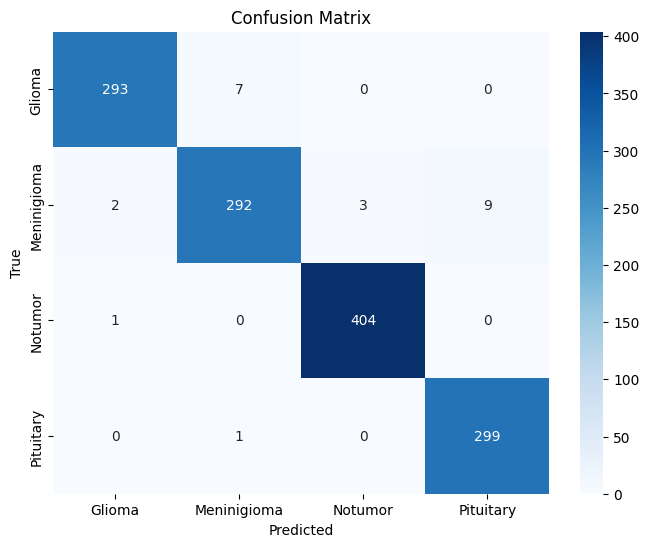

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()